In [7]:
# Install a pip package in the current Jupyter kernel
import sys
import os
sys.path.append('../')
sys.path.append('../WD_models')
sys.path.append('../corv/src')


### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import astropy
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join

from tqdm import tqdm
import pandas as pd
from scipy.optimize import curve_fit
import scipy.stats as stats

### Tools
import data_selector as ds
import WD_models
from bisect import bisect_left
import lmfit
import glob

from astroquery.sdss import SDSS
from astroquery.gaia import Gaia

#corv.sdss.make_catalogs()

In [8]:
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

In [9]:
from __future__ import print_function
from astropy.coordinates import SkyCoord
import astropy.units as u
from dustmaps.bayestar import BayestarQuery

coords = SkyCoord('12h30m25.3s', '15d15m58.1s', distance = 200 * u.kpc, frame='icrs')
bsq = BayestarQuery()
ebv = bsq.query(coords)

coords = SkyCoord('12h30m25.3s', '15d15m58.1s', distance = 200 * u.kpc, frame='icrs')
print('E(B-V) = {:.3f} mag'.format(ebv))
#print(ebv)

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 66.709 s
  pix_info:   1.287 s
   samples:  18.145 s
      best:  22.632 s
       nan:   8.239 s
      sort:  11.639 s
       idx:   4.767 s
E(B-V) = 0.050 mag


In [93]:
catalog = Table.read('data/00_raw.fits')

drop_cols = []
keep_cols = ['wd_l', 'wd_b', 'ms_parallax', 'wd_source_id', 'wd_bp_rp', 'wd_m_g']

for key in catalog.keys():
    if key not in keep_cols:
        drop_cols.append(key)
        
catalog.remove_columns(drop_cols)

alldat = catalog.copy()


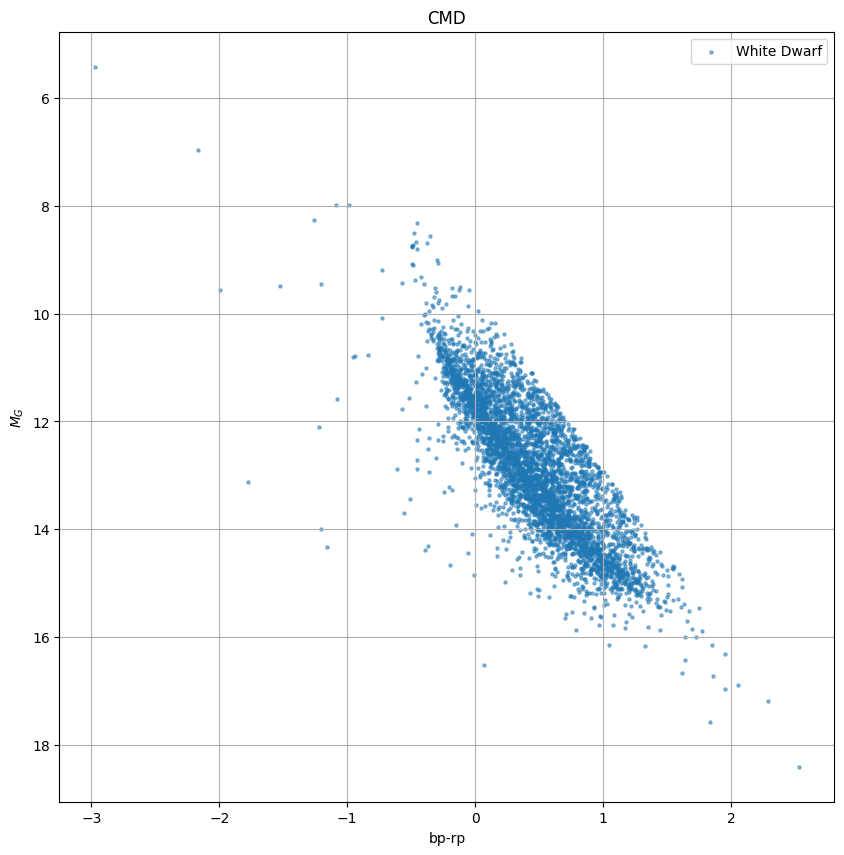

In [94]:
plt.figure(figsize=(10,10))

plt.scatter(catalog['wd_bp_rp'], catalog['wd_m_g'], label='White Dwarf', alpha = 0.5, s=5)

plt.grid()
plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

plt.legend()
plt.show()

(PAPER TO UPDATE THIS LATER)[https://iopscience.iop.org/article/10.1088/0004-637X/737/2/103#apj398709t6]

In [95]:
coords = [SkyCoord(frame="galactic", l=catalog['wd_l'][i]*u.deg, b=catalog['wd_b'][i]*u.deg, distance = (1000/catalog['ms_parallax'][i]) * u.pc) for i in range(len(catalog))]
catalog['wd_coords'] = coords

In [96]:
bsq.query(catalog['wd_coords'][0], return_flags = True)

[0.0, (True, False)]

In [97]:
ebv = []
flag1 = []
flag2 = []

for i in tqdm(range(len(catalog))):
    bsq_res = bsq.query(catalog['wd_coords'][i], return_flags = True)
        
    ebv.append(bsq_res[0])
    flag1.append(bsq_res[1][0])
    flag2.append(bsq_res[1][1])
    
catalog['E(B-V)'] = ebv
catalog['converged'] = flag1
catalog['reliable_dist'] = flag2

100%|██████████████████████████████████████████████████████████████████████| 4490/4490 [00:43<00:00, 104.28it/s]


In [98]:
print(catalog['wd_source_id'])

    wd_source_id   
-------------------
4282299551960647680
3124538851862773120
3050837938914366592
6129251625151149952
 455517329408362752
 455168200100958336
 277090540953615616
6032719211516656256
3045896351404348672
5544346550534282496
4308522869965350656
                ...
5548648634588556288
5552022211141079296
5553354505701767296
 161654773656107264
 161790765206804480
 160609820997846528
2164850850772924800
2915268911120796928
2913967501671606656
2913069917928896896
2913165270498534144
Length = 4490 rows


In [99]:
ADQL_CODE1 = "SELECT \
        sdss.original_ext_source_id as bestobjid,\
        gaia_source.source_id\
        FROM gaiaedr3.gaia_source \
        JOIN gaiaedr3.sdssdr13_best_neighbour as sdss\
        ON gaia_source.source_id = sdss.source_id      \
        WHERE gaia_source.source_id IN {}\
    ".format(tuple(catalog['wd_source_id']))

job1 = Gaia.launch_job(ADQL_CODE1,dump_to_file=False)
d1 = job1.get_results()

In [100]:
print(d1)

     bestobjid           source_id     
------------------- -------------------
1237678619047624732    1243753812038656
1237667229302194320    6963383233077632
1237670016735772722    7027562929324416
1237670017271463972    8192736017677184
1237667228761981025   19181598822046976
1237671258514588102   45173473883595776
1237664088605130795   48883840294734208
1237673285200445513   56413781254648960
1237666276362747951   56529573573742848
1237673285735154158   59506604382920576
1237649954947399744   74803108933097216
                ...                 ...
1237671958600941596 6298199691362822144
1237678536867774613 6834550603080004864
1237668758316318753 6883183376772973184
1237678537942761651 6884368925181972736
1237678537944137773 6891769428709519872
1237678536870592602 6892219644359395584
1237652600102387794 6898255177217741952
1237652934034063869 6898444632519864448
1237652599023403342 6908108244513766272
1237680263445020810 6911308235665163264
1237679077495865468 6915495141583341824


In [101]:
drops = []
bestobjid1 = []

for i in tqdm (range(len(catalog))):
    notfound = False
    a = np.where(d1['source_id'] == catalog['wd_source_id'][i])
    
    try:
        j = a[0][0]
    except:
        notfound = True
        
    if not notfound: 
        try:
            bestobjid1.append(d1['bestobjid'][j])
        except:
            notfound = True
    if notfound:
        drops.append(i)    
        
catalog.remove_rows(drops)
catalog['wd_bestobjid'] = bestobjid1

100%|█████████████████████████████████████████████████████████████████████| 4490/4490 [00:00<00:00, 8184.18it/s]


In [102]:
print(catalog['wd_bestobjid'])

    wd_bestobjid   
-------------------
1237667136955416672
1237666464265994487
1237667207828799608
1237668658989761033
1237667205679677575
1237679477466661011
1237672764441952307
1237672763904753827
1237680275256049763
1237678542236483670
1237678540088016952
                ...
1237662530607644949
1237668311090593860
1237668336321495175
1237665547825185381
1237667782320324692
1237665566081679524
1237667735599841356
1237667782856147342
1237658220601934186
1237658187854053542
1237663787955978273
Length = 1108 rows


In [103]:
from astropy.table import Table, vstack, hstack

stardats = []
iters = len(catalog) // 100

for i in tqdm(range(iters)):
    SDSS_QUERY = """select ObjID, psfMag_u, psfMagErr_u, psfMag_g, psfMagErr_g, psfMag_r, psfMagErr_r, psfMag_i, psfMagErr_i, psfMag_z, psfMagErr_z, clean, insideMask
    from dbo.PhotoObjAll
    where ObjID in {}""".format(tuple(catalog['wd_bestobjid'][100*i:100*i+100]))
    
    stardats.append(SDSS.query_sql(SDSS_QUERY))
phot = vstack(stardats)

100%|███████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21.69it/s]


In [104]:
print(phot)

       ObjID        psfMag_u psfMagErr_u psfMag_g psfMagErr_g ... psfMag_z psfMagErr_z clean insideMask
------------------- -------- ----------- -------- ----------- ... -------- ----------- ----- ----------
1237680275256049763 19.84923    1.245677 19.33575    2.432386 ... 21.75953   0.5274124     0         16
1237679078036471855 19.73565  0.05733685 19.62783  0.02981794 ... 20.36814   0.2429479     0          2
1237679006634213444 18.03071  0.04507602 17.88807  0.01850622 ... 18.46011  0.04347789     1          0
1237679006633033800 24.69429    1.214786 21.36485   0.2383602 ... 19.91552   0.2542988     0          0
1237667255616209053 19.81926  0.03794575 19.45858  0.03085722 ... 19.51658  0.06767099     1          0
1237667255615750198 20.04991  0.05195004 19.70997  0.02648246 ... 19.85134   0.1412876     0          0
1237667253991702787 23.06827    105.5225 25.11387    152.5454 ... 18.08719    6.596126     0          0
1237667253990457525 18.25535  0.01938976 17.80433  0.01885181 ..

In [105]:
drops = []
Su = []
Sg = []
Sr = []
Si = []
Sz = []

fu = []
fg = []
fr = []
fi = []
fz = []

e_Su = []
e_Sg = []
e_Sr = []
e_Si = []
e_Sz = []

clean = []
inmask = []

for i in tqdm (range(len(catalog))):
    notfound = False
    a = np.where(phot['ObjID'] == catalog['wd_bestobjid'][i])
    
    try:
        j = a[0][0]
    except:
        notfound = True
        
    if not notfound: 
        Su.append(phot['psfMag_u'][j])
        Sg.append(phot['psfMag_g'][j])
        Sr.append(phot['psfMag_r'][j])
        Si.append(phot['psfMag_i'][j])
        Sz.append(phot['psfMag_z'][j])
        
        e_Su.append(phot['psfMagErr_u'][j])
        e_Sg.append(phot['psfMagErr_g'][j])
        e_Sr.append(phot['psfMagErr_r'][j])
        e_Si.append(phot['psfMagErr_i'][j])
        e_Sz.append(phot['psfMagErr_z'][j])
        
        clean.append(phot['clean'][j])
        inmask.append(phot['insideMask'][j])
    else:
        drops.append(i)    
        
catalog.remove_rows(drops)
catalog['u'] = Su# + 5 * np.log10(catalog['wd_parallax'] / 100)
catalog['g'] = Sg# + 5 * np.log10(catalog['wd_parallax'] / 100)
catalog['r'] = Sr# + 5 * np.log10(catalog['wd_parallax'] / 100)
catalog['i'] = Si# + 5 * np.log10(catalog['wd_parallax'] / 100)
catalog['z'] = Sz# + 5 * np.log10(catalog['wd_parallax'] / 100)

catalog['err_u'] = e_Su
catalog['err_g'] = e_Sg
catalog['err_r'] = e_Sr
catalog['err_i'] = e_Si
catalog['err_z'] = e_Sz

catalog['clean'] = clean
catalog['insideMask'] = inmask
#catalog.reset_index(inplace=True, drop=True)

100%|████████████████████████████████████████████████████████████████████| 1108/1108 [00:00<00:00, 15159.82it/s]


In [106]:
catalog['A_u'] = np.repeat(np.nan, len(catalog))
catalog['A_g'] = np.repeat(np.nan, len(catalog))
catalog['A_r'] = np.repeat(np.nan, len(catalog))
catalog['A_i'] = np.repeat(np.nan, len(catalog))
catalog['A_z'] = np.repeat(np.nan, len(catalog))

for obj in tqdm(catalog):
    obj['A_u'] = obj['E(B-V)'] * 3.518
    obj['A_g'] = obj['E(B-V)'] * 2.617
    obj['A_r'] = obj['E(B-V)'] * 1.971
    obj['A_i'] = obj['E(B-V)'] * 1.549
    obj['A_z'] = obj['E(B-V)'] * 1.263
    
catalog['dered_u'] = catalog['u'] - catalog['A_u']
catalog['dered_g'] = catalog['g'] - catalog['A_g']
catalog['dered_r'] = catalog['r'] - catalog['A_r']
catalog['dered_i'] = catalog['i'] - catalog['A_i']
catalog['dered_z'] = catalog['z'] - catalog['A_z']

catalog['r_est'] = 1000 / catalog['ms_parallax']

100%|████████████████████████████████████████████████████████████████████| 1100/1100 [00:00<00:00, 20286.39it/s]


In [107]:
font_model = WD_models.load_model('f', 'f', 'f', 'H', HR_bands = ['Su-Sg', 'Su'])

g_acc = (10**font_model['logg'])/100
rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
logg_teff_to_rsun = WD_models.interp_xy_z_func(x = font_model['logg'], y = 10**font_model['logteff'],
                                            z = rsun, interp_type = 'linear')

fitsed = WD_models.FitSED(to_flux = False, atm_type = 'H', bands = ['Su', 'Sg', 'Sr', 'Si', 'Sz'])

initialized with atm_type = H and bands = ['Su', 'Sg', 'Sr', 'Si', 'Sz']


In [108]:
def mag_to_flux(mag):
    return 10 ** ((mag + 48.6)/ -2.5) 

def flux_to_mag(flux):
    return -2.5 * np.log10(flux) - 48.60
    
def get_model_flux(params):
    
    teff, logg, radius, distance = params['teff'], params['logg'], params['radius'], params['distance']
    
    model_mag = fitsed.model_sed(teff, logg, plx = 100)
    model_flux = mag_to_flux(model_mag)
    
    rsun = logg_teff_to_rsun(logg, teff)
    corr_radius = rsun * radius_sun
    corr_distance = 10 * pc_to_m
    
    corr_model_flux = model_flux / (4 * np.pi * (corr_radius / corr_distance)**2)
    
    radius = radius * radius_sun # Rsun to meter
    distance = distance * pc_to_m # Parsec to meter
     
    flux = corr_model_flux * ( 4 * np.pi * (radius / distance)**2 )
    
    return flux_to_mag(flux)
    

def residual(params, obs_flux = None, e_obs_flux = None):
    model_flux = (get_model_flux(params))

    chisquare = ((model_flux - obs_flux) / e_obs_flux)**2
    
    #chisquare[np.isnan(chisquare)] = 1e8
    return chisquare

In [119]:
def get_parameters(obs_mag, e_obs_mag, id_ = None, floor_error = 0.02, make_plot = False, vary_logg = False, p0 = [10000, 8, 0.01, 100]):      
    
    #obs_flux = (mag_to_flux(obs_mag))
    #obs_flux = obs_mag
    
    e_obs_mag = np.sqrt(e_obs_mag**2 + floor_error**2)
    #e_obs_flux = (e_obs_mag * obs_flux)
    
    #print('max: ' + str(max(obs_flux)))
    #print('min: ' + str(min(obs_flux)))
    
    params = lmfit.Parameters()

    params.add('teff', value = p0[0], min = 3500, max = 55000, vary = True)
    params.add('logg', value = p0[1], min=7.5, max=9, vary=vary_logg)
    params.add('radius', value = p0[2], min = 0.0001, max = 0.05, vary = True)
    params.add('distance', value = p0[3], min = 1, max = 2000, vary = False)
        
    #result = lmfit.minimize(residual, params, kws = dict(obs_flux = obs_flux, e_obs_flux = e_obs_flux), method = 'emcee', steps = 5000, burn = 500, thin = 20, is_weighted = False, progress = False)
    result = lmfit.minimize(residual, params, kws = dict(obs_flux = obs_mag, e_obs_flux = e_obs_mag), method = 'leastsq')
    
    #result.params.pretty_print()
        
    return result

In [120]:
n_logg = 100
logg_grid = np.linspace(7.5, 9, num = n_logg)

teff_10k = lmfit.Parameters()
teff_10k.add('teff', value = 10000)
teff_10k.add('logg', value = 8)
teff_10k.add('radius', value = 0.01)
teff_10k.add('distance', value = 200)

teff_3k = lmfit.Parameters()
teff_3k.add('teff', value = 3500)
teff_3k.add('logg', value = 8)
teff_3k.add('radius', value = 0.01)
teff_3k.add('distance', value = 200)

teff_50k = lmfit.Parameters()
teff_50k.add('teff', value = 50000)
teff_50k.add('logg', value = 8)
teff_50k.add('radius', value = 0.01)
teff_50k.add('distance', value = 200)

flux_3k = get_model_flux(teff_3k)
flux_10k = get_model_flux(teff_10k)
flux_50k = get_model_flux(teff_50k)

results_10k = []
results_3k = []
results_50k = []

for logg in logg_grid:
    results_3k.append(get_parameters(flux_3k, np.array([0.03,0.03,0.03,0.03,0.03]), p0 = [10000, logg, 0.01, 200]))
    results_10k.append(get_parameters(flux_10k, np.array([0.03,0.03,0.03,0.03,0.03]), p0 = [10000, logg, 0.01, 200]))
    results_50k.append(get_parameters(flux_50k, np.array([0.03,0.03,0.03,0.03,0.03]), p0 = [10000, logg, 0.01, 200]))

In [125]:
results = []
results7 = []
results9 = []
e_results = []

catalog['phot_id'] = np.ones(len(catalog))
for i in range(len(catalog)):
    catalog['phot_id'][i] = int(i)


logg_vary = []

for i in tqdm(range(len(catalog))):
    obs_mag = np.array([catalog['u'][i] - 0.040, catalog['g'][i], catalog['r'][i], catalog['i'][i] + 0.015, catalog['z'][i] + 0.030])
    e_obs_mag = np.array([catalog['err_u'][i], catalog['err_g'][i], catalog['err_r'][i], catalog['err_i'][i], catalog['err_z'][i]])
    
    #logg7 = get_parameters(obs_mag, e_obs_mag, vary_logg=False, p0 = [10000, 7, 0.003, catalog['r_est'][i]] )
    logg8 = get_parameters(obs_mag, e_obs_mag, id_ = catalog['phot_id'][i], vary_logg=False, p0 = [10000, 8, 0.003, catalog['r_est'][i]])
    #logg9 = get_parameters(obs_mag, e_obs_mag, vary_logg=False, p0 = [10000, 9, 0.003, catalog['r_est'][i]] )
    
    #plots.append(plot)
    
    results.append(logg8)
    results7.append(logg7)
    results9.append(logg9)
    #logg_vary.append(get_parameters(obs_mag, e_obs_mag, vary_logg = True, p0 = [10000, 8, 0.01, catalog['r_est'][i]]))

100%|███████████████████████████████████████████████████████████████████████| 1100/1100 [00:12<00:00, 89.88it/s]


 50%|███████████████████████████████████▎                                   | 548/1100 [00:02<00:02, 218.00it/s]/tmp/ipykernel_10910/1754622065.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = (8,7))
100%|██████████████████████████████████████████████████████████████████████| 1100/1100 [00:04<00:00, 223.15it/s]


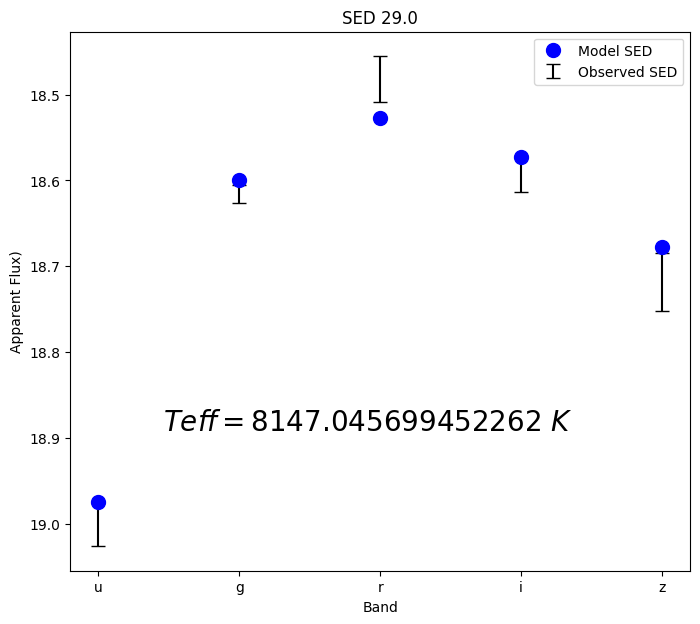

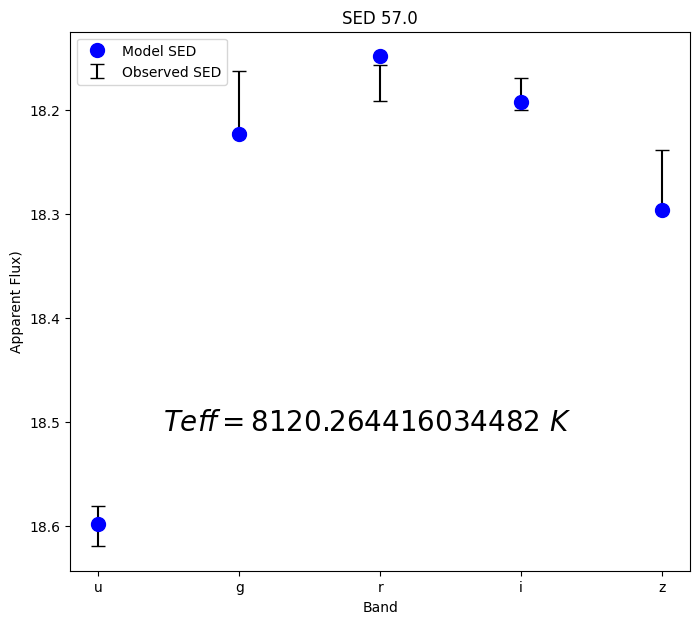

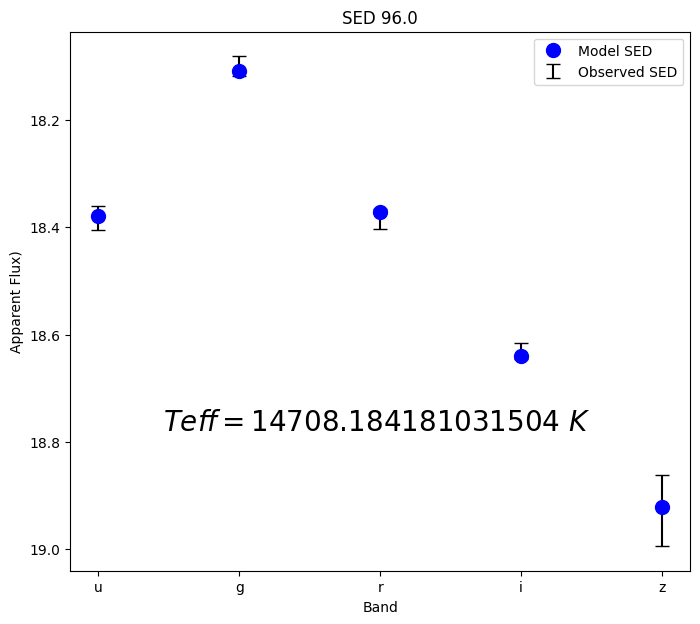

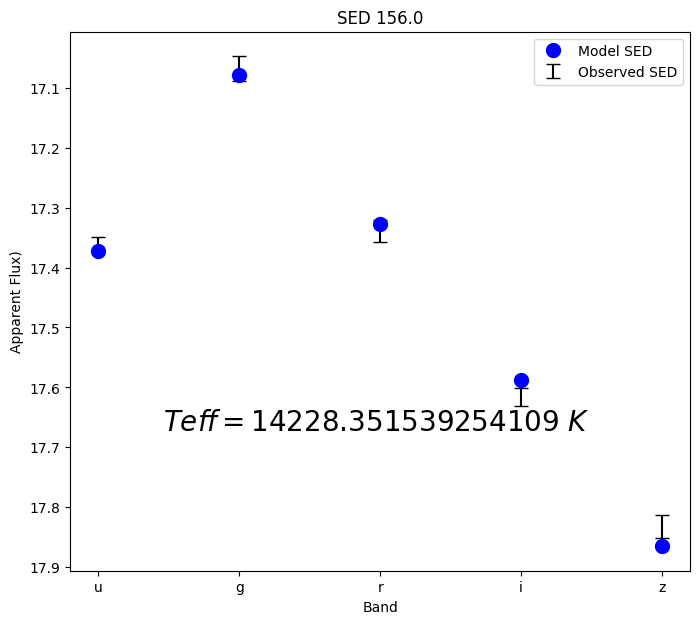

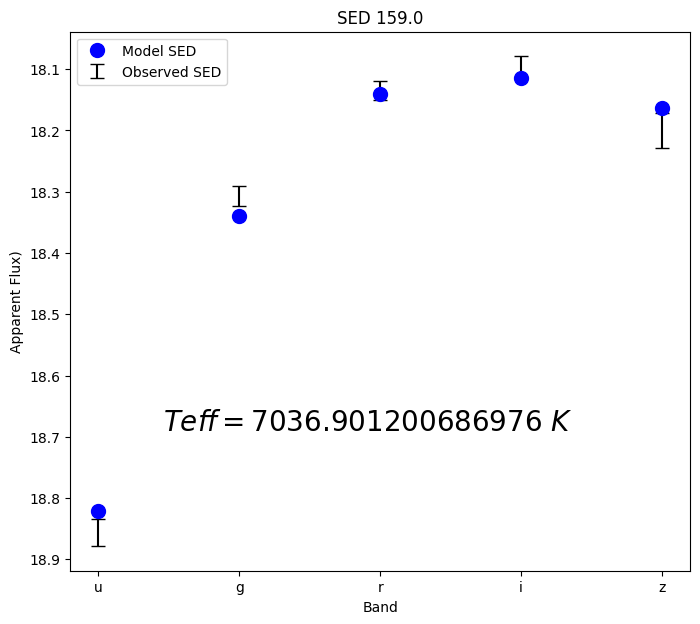

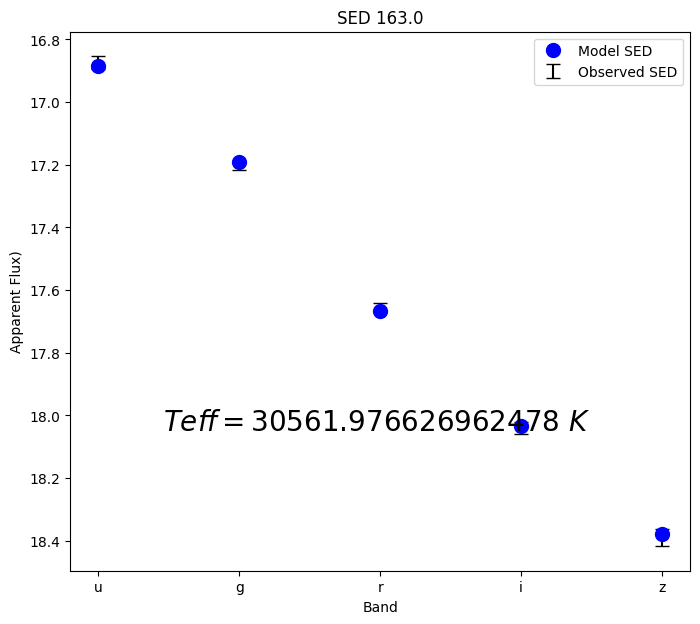

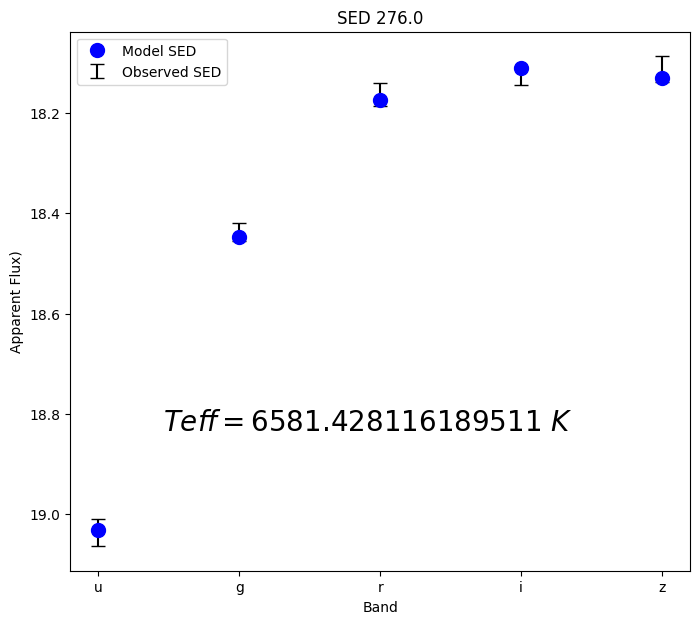

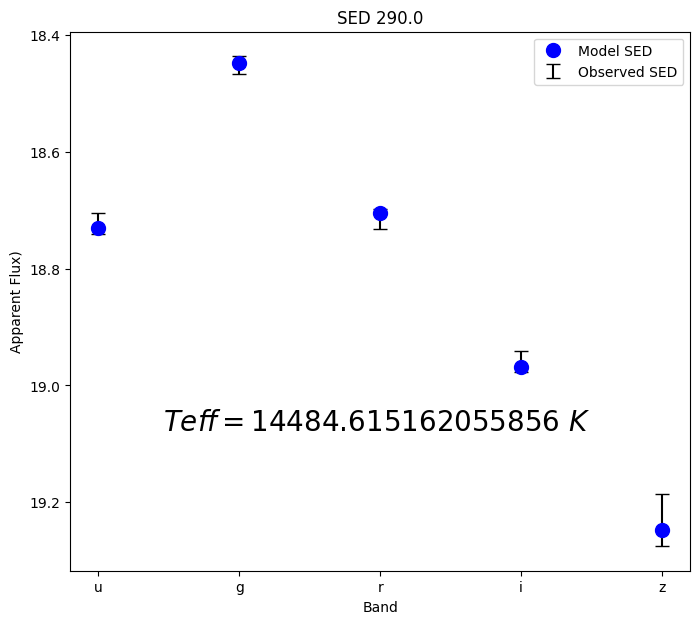

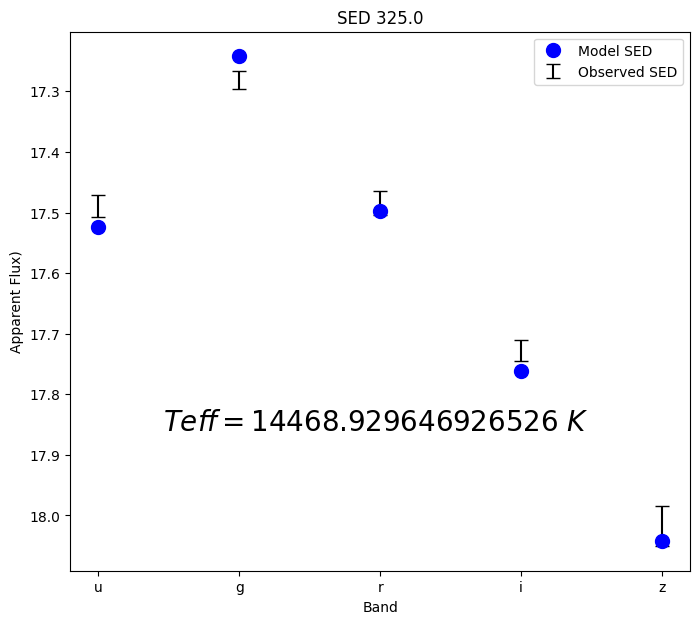

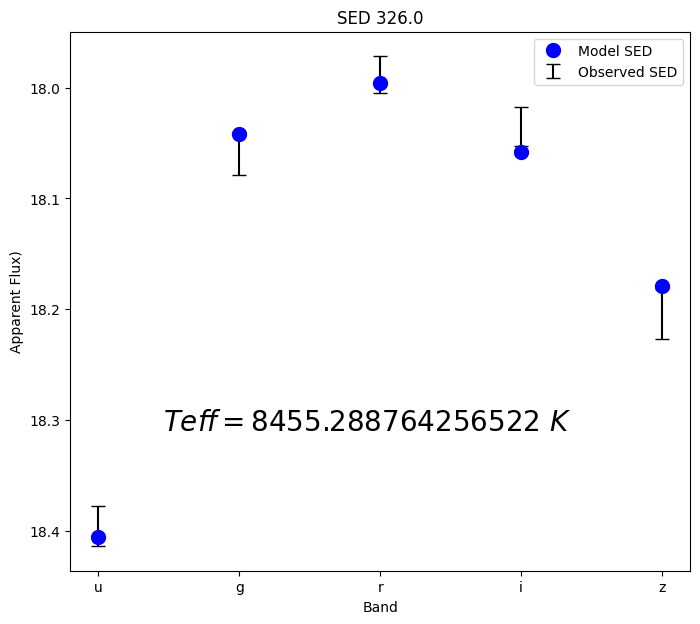

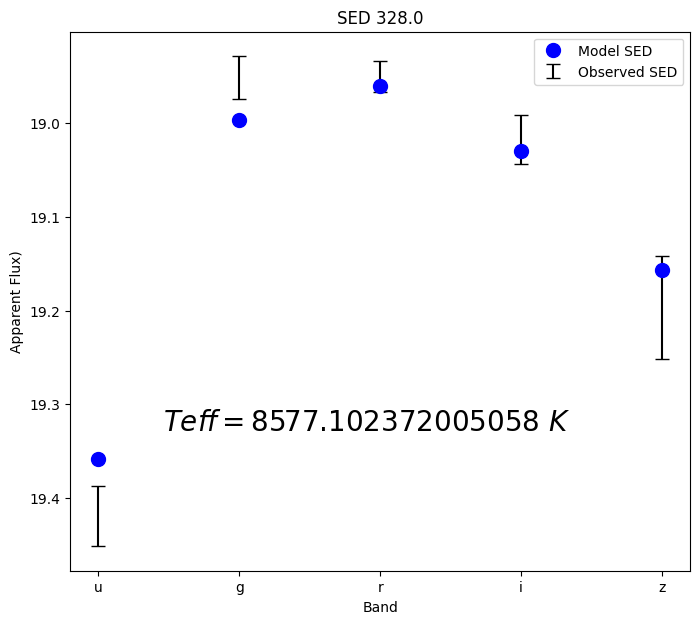

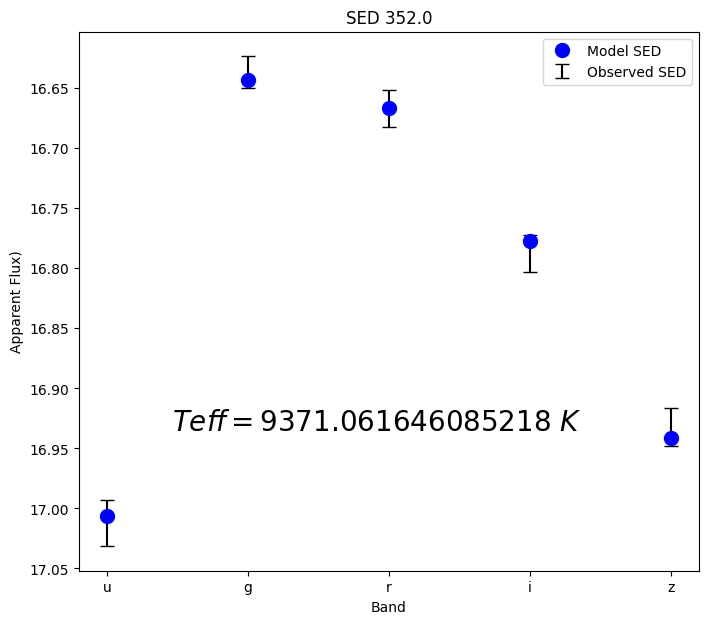

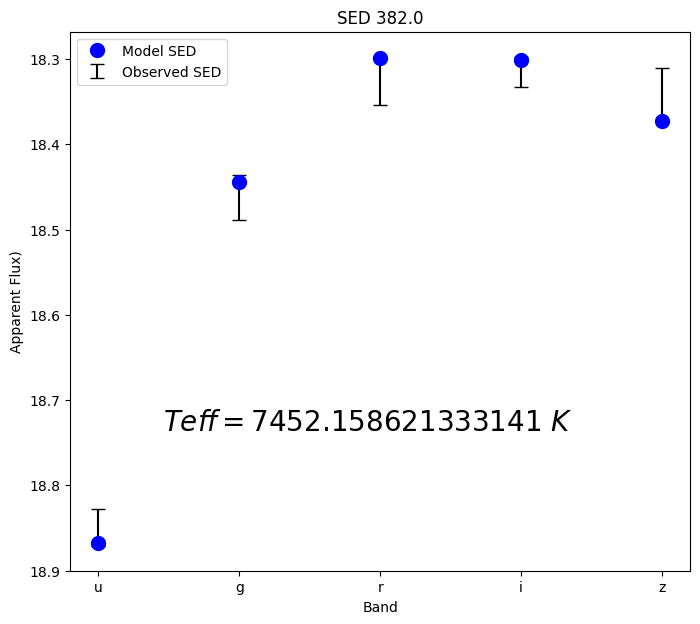

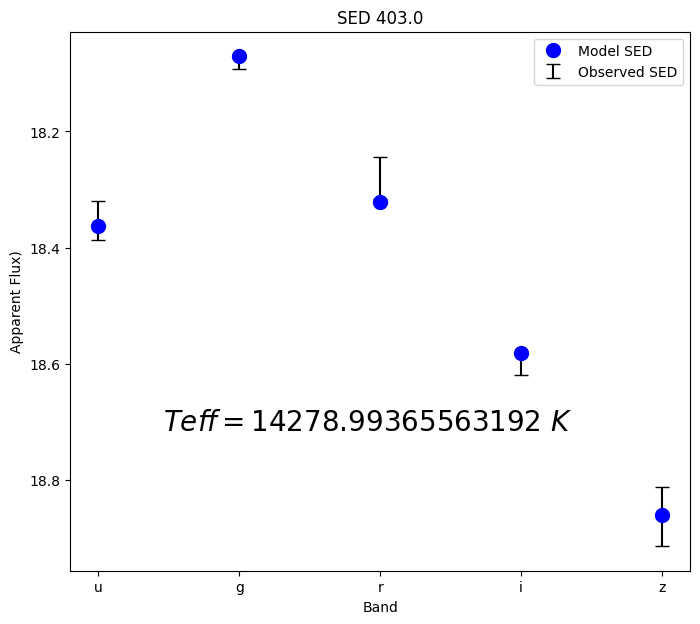

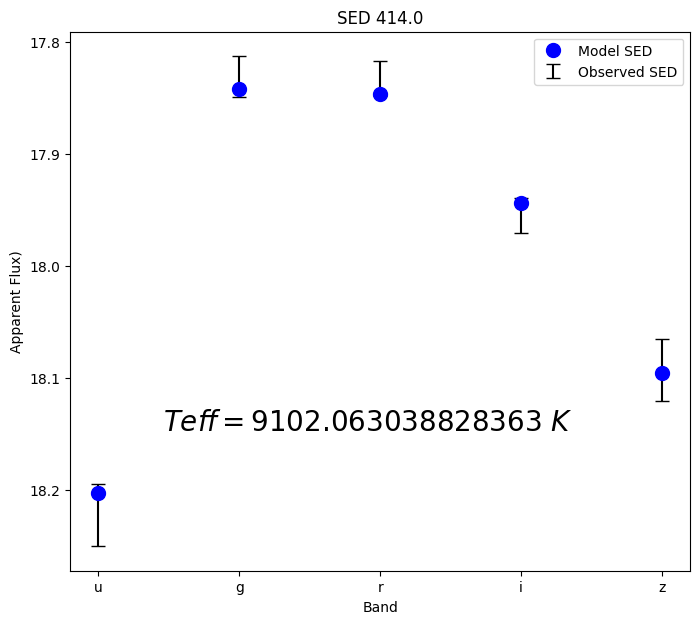

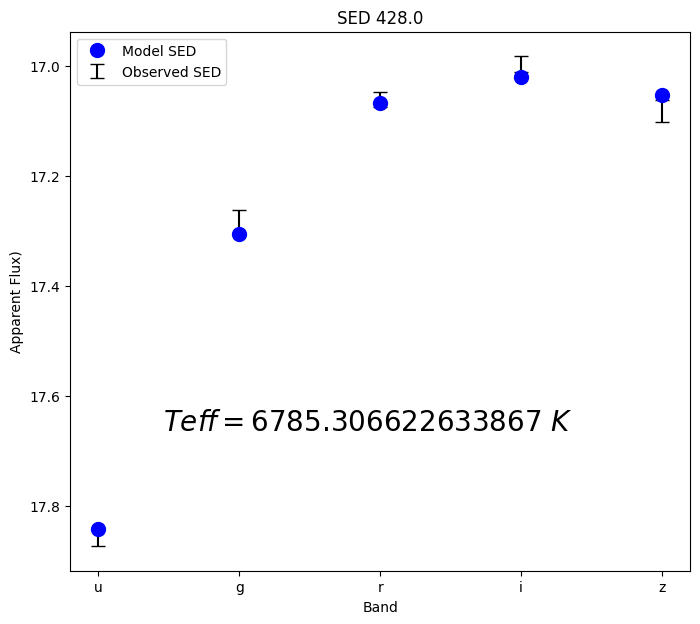

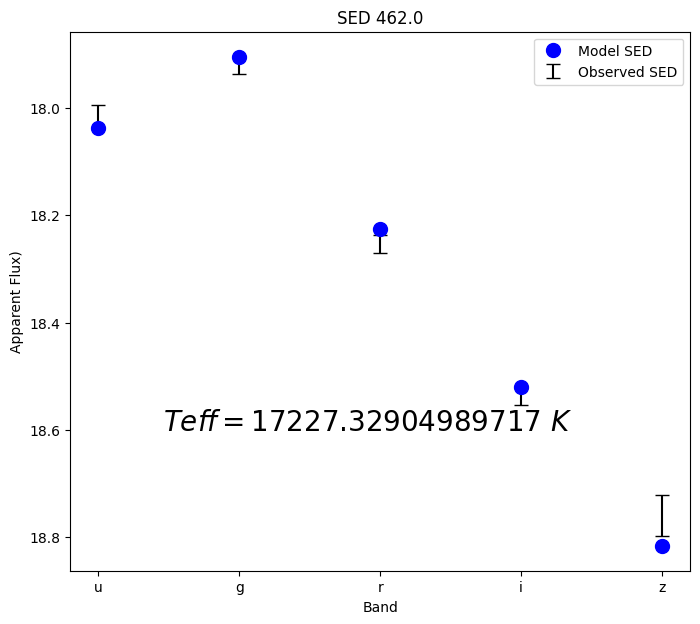

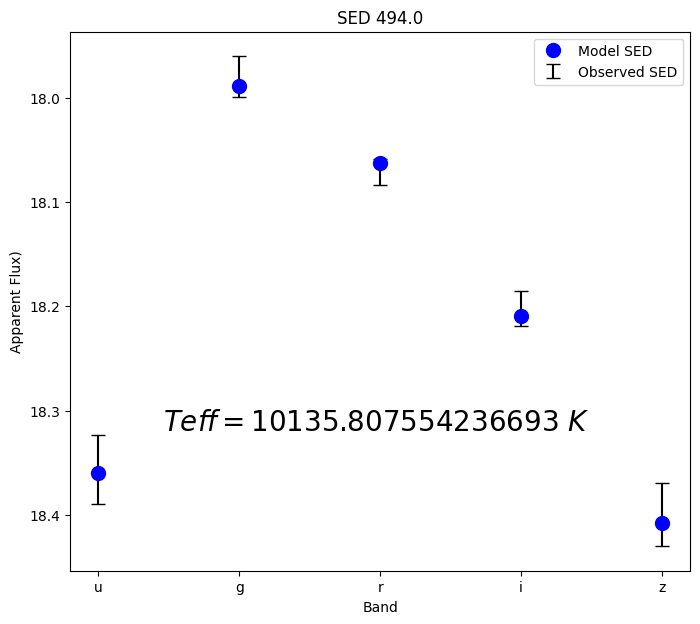

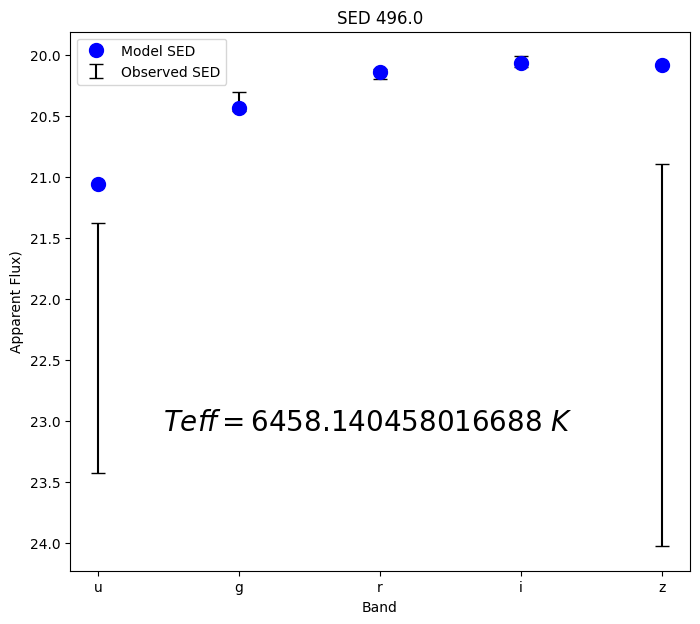

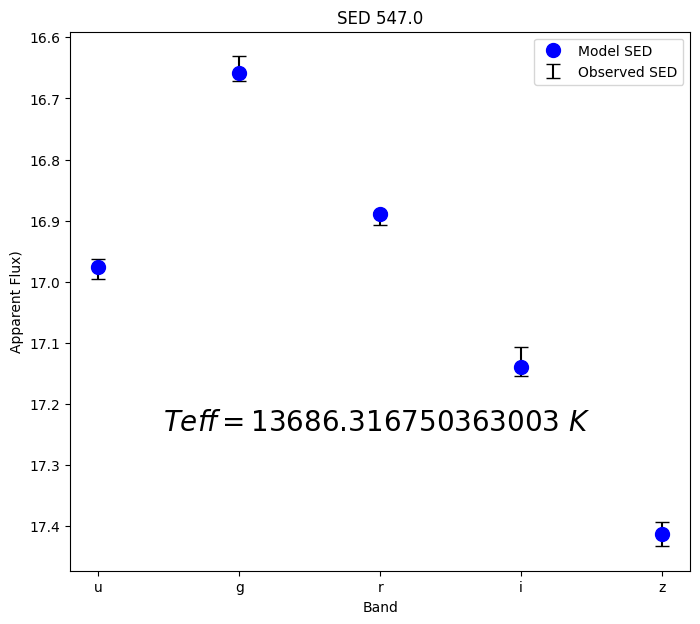

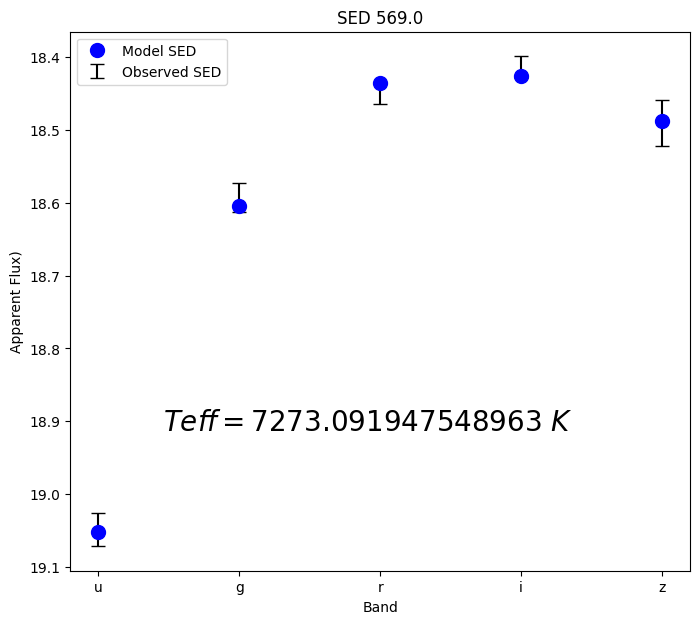

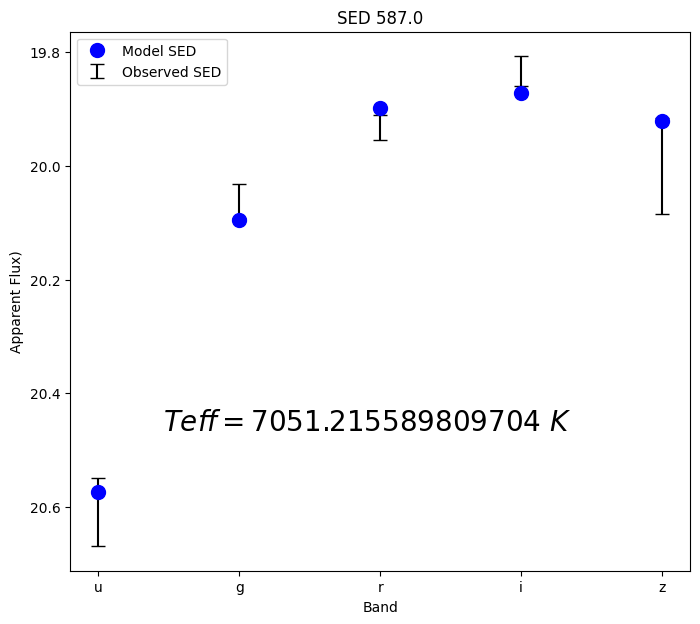

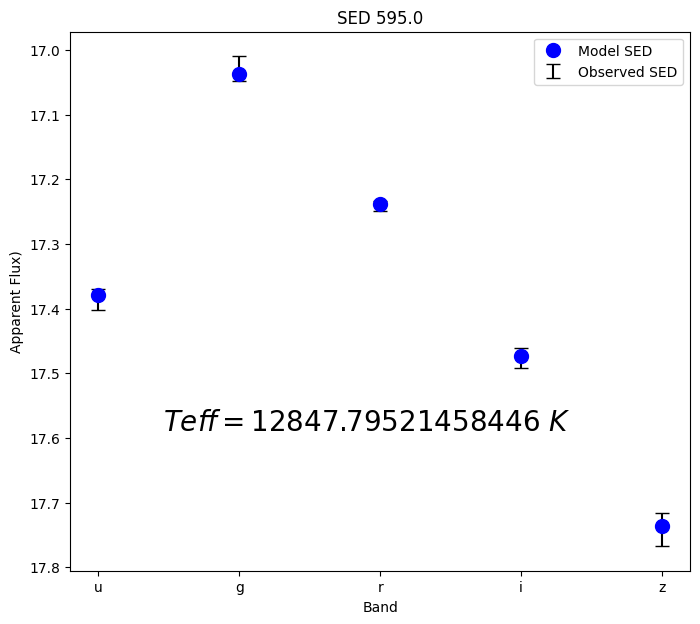

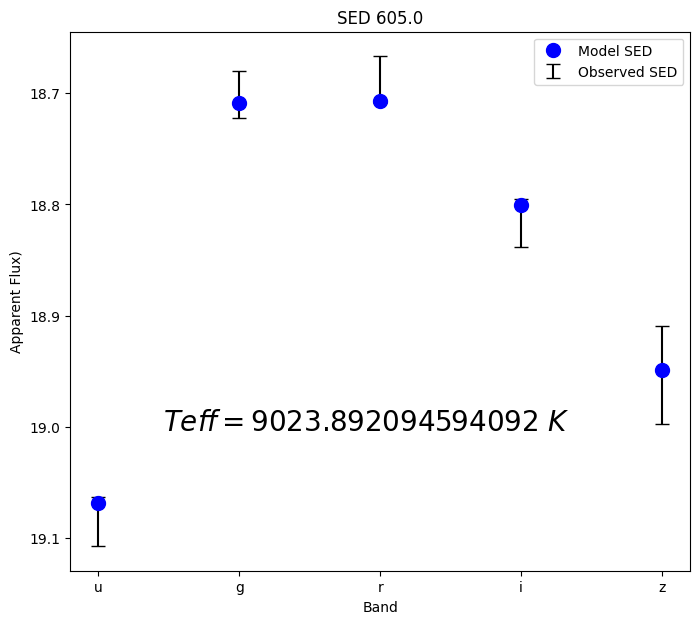

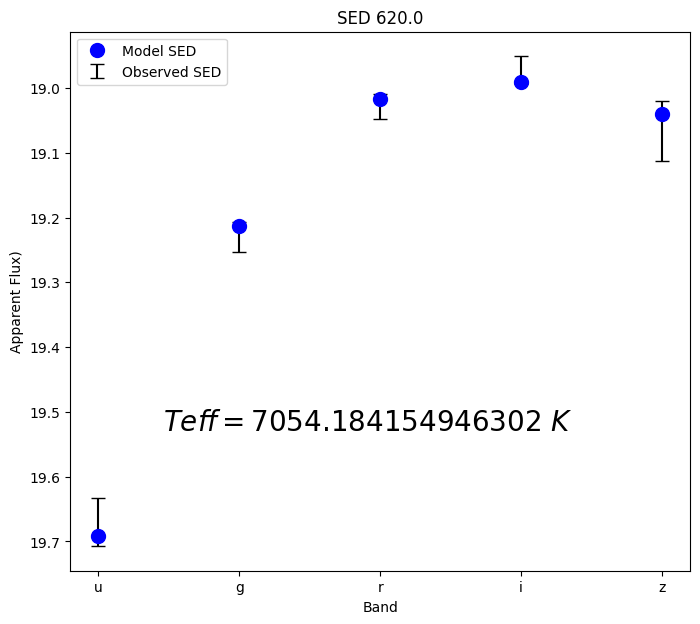

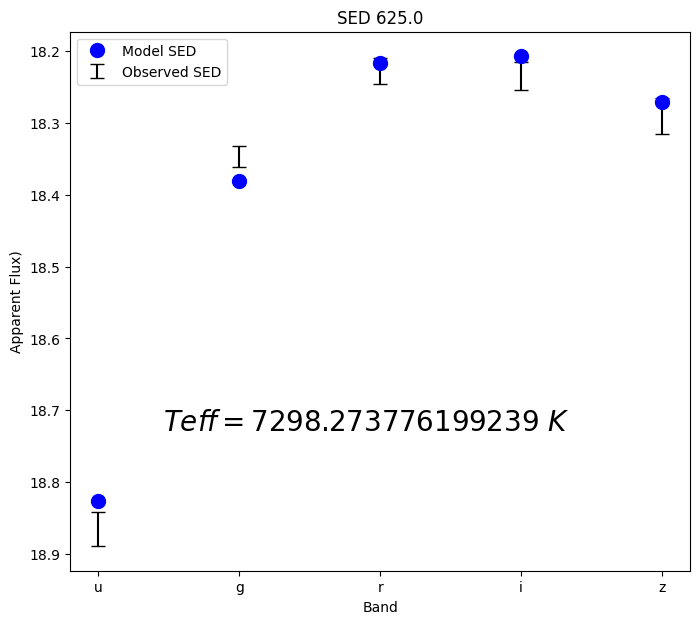

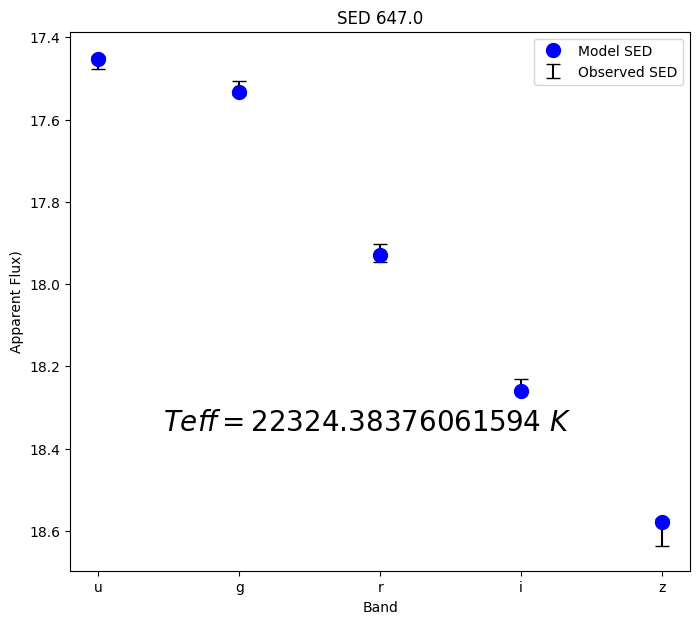

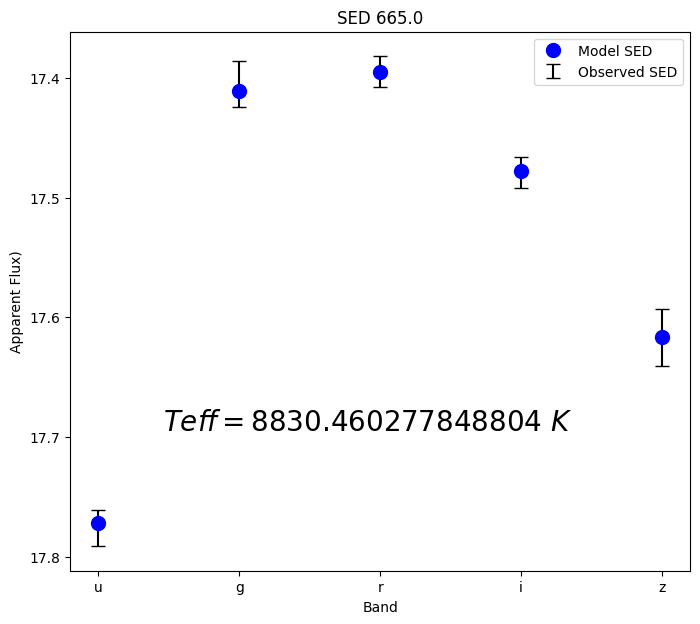

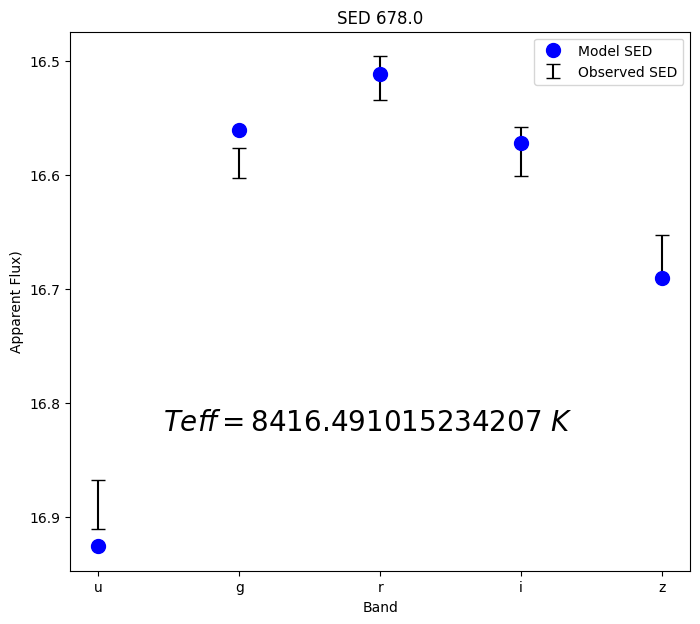

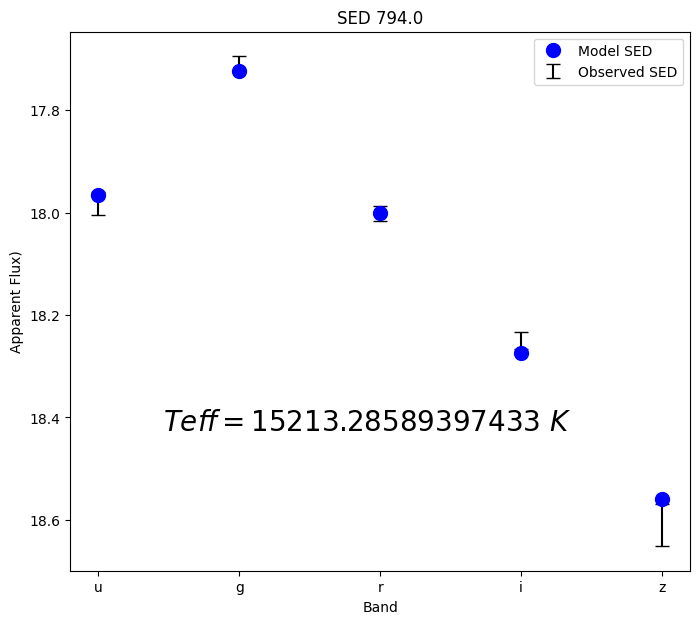

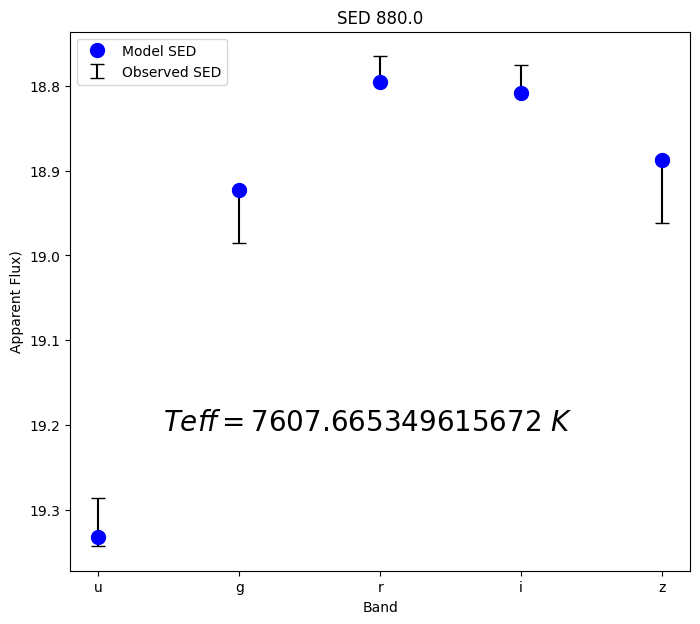

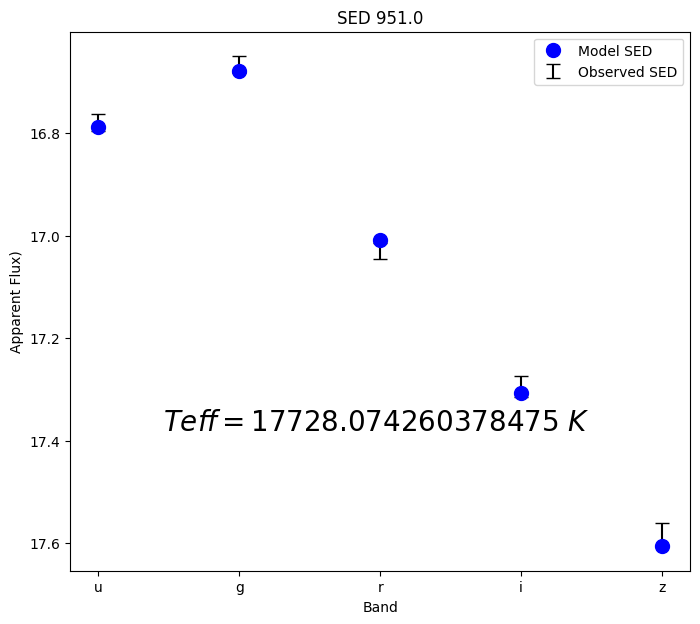

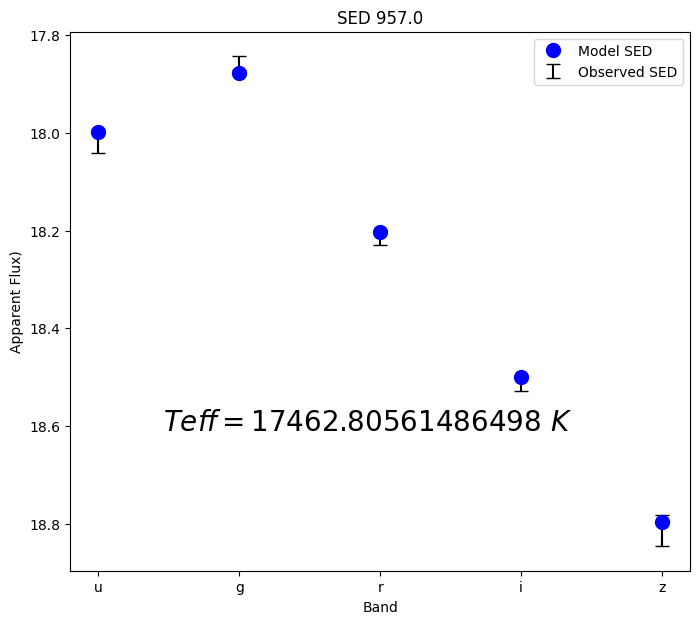

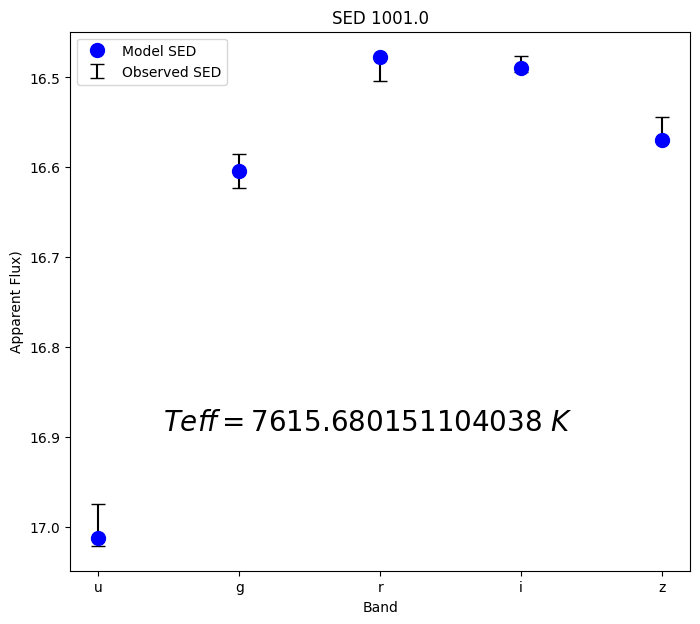

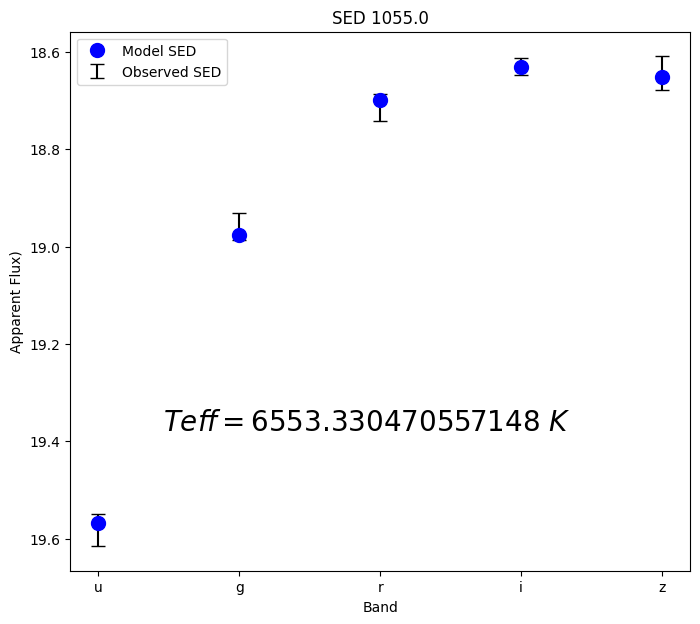

In [126]:
refs = Table.read('data/final_sourceids.fits')

for i in tqdm(range(len(catalog))):
    if catalog['wd_source_id'][i] in refs['wd_source_id']:
        bands = ['u', 'g', 'r', 'i', 'z']
        
        fig = plt.figure(figsize = (8,7))
        plt.errorbar(bands, [catalog['u'][i] - 0.040, catalog['g'][i], catalog['r'][i], catalog['i'][i] + 0.015, catalog['z'][i] + 0.030],
                     yerr = [catalog['err_u'][i], catalog['err_g'][i], catalog['err_r'][i], catalog['err_i'][i], catalog['err_z'][i]],
                     linestyle = 'none', marker = 'None', color = 'k', capsize = 5, label = 'Observed SED')
        plt.plot(bands, get_model_flux(results[i].params), 'bo', markersize = 10, label = 'Model SED')
        plt.title('SED {}'.format(catalog['phot_id'][i]))
        plt.text(0.15, 0.26, r'$Teff = ${} $K$'.format(results[i].params['teff'].value), transform = plt.gca().transAxes, fontsize=20)
        plt.xlabel('Band')
        plt.ylabel('Apparent Flux)')
        plt.gca().invert_yaxis()
        plt.legend() 
        plt.savefig('./spectra/nedler/{}.png'.format(catalog['phot_id'][i]))

In [127]:
print(results[0])

In [128]:
vary_catalog = catalog.copy()

catalog['raw_radius_result'] = [result for result in results]
catalog['radius'] = [result.params['radius'].value for result in results]
catalog['phot_teff'] = [result.params['teff'].value for result in results]
catalog['e_phot_teff'] = [result.params['teff'].stderr for result in results]
catalog['redchi'] = [result.redchi for result in results]
catalog['e_radius'] = [np.sqrt(results[i].params['radius'].stderr**2 + np.abs(results7[i].params['radius'].value - results9[i].params['radius'].value)**2 ) for i in range(len(results))]
catalog['error_from_model'] = [np.abs(results7[i].params['radius'].value - results9[i].params['radius'].value) for i in range(len(results))]

#vary_catalog['radius'] = [result.params['radius'].value for result in logg_vary]
#vary_catalog['teff'] = [result.params['teff'].value for result in logg_vary]
#vary_catalog['e_teff'] = [result.params['teff'].stderr for result in logg_vary]
#vary_catalog['redchi'] = [result.redchi for result in logg_vary]
#vary_catalog['e_radius'] = [result.params['radius'].stderr for result in logg_vary]

 55%|███████████████████████████████████████▎                               | 610/1100 [00:03<00:01, 350.45it/s]/tmp/ipykernel_10910/3901330880.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = (8,7))
100%|██████████████████████████████████████████████████████████████████████| 1100/1100 [00:04<00:00, 247.98it/s]


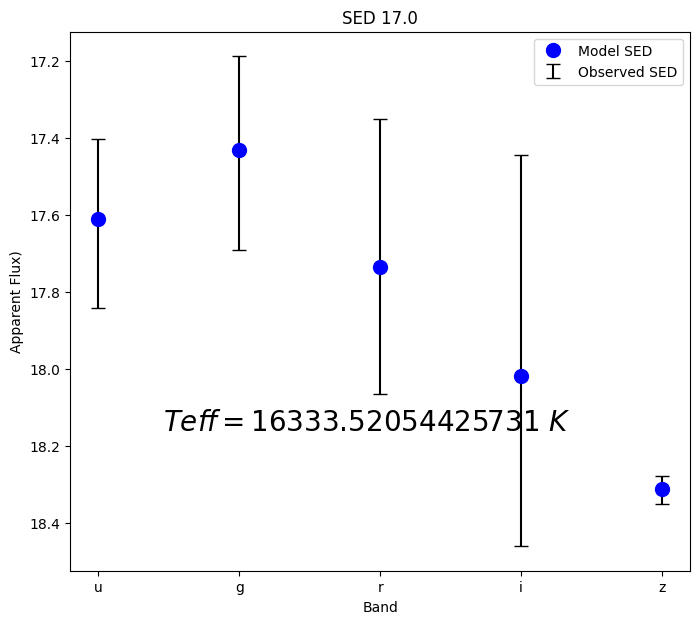

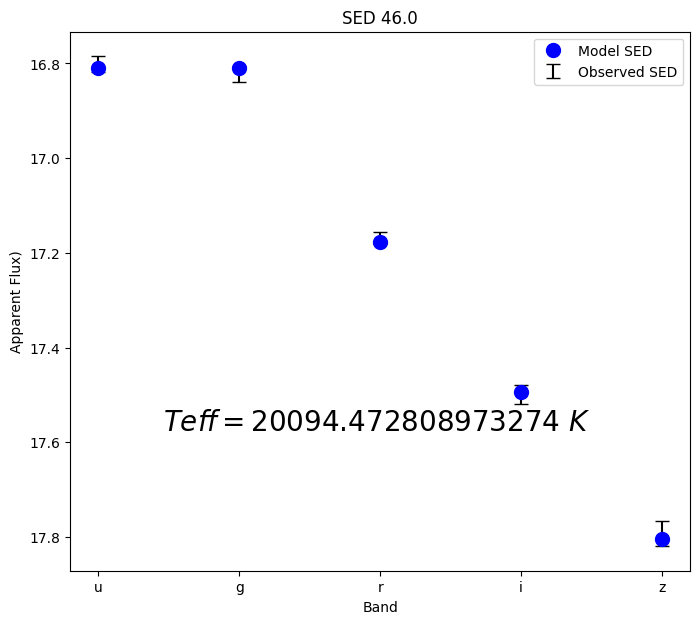

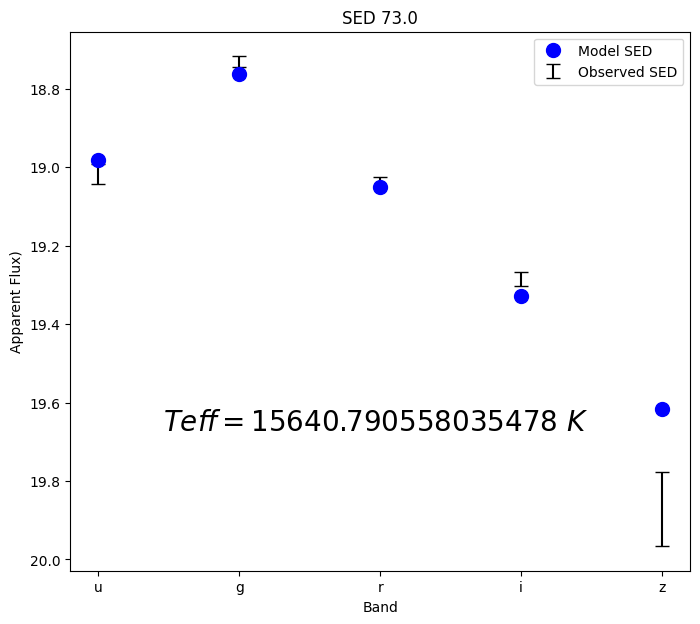

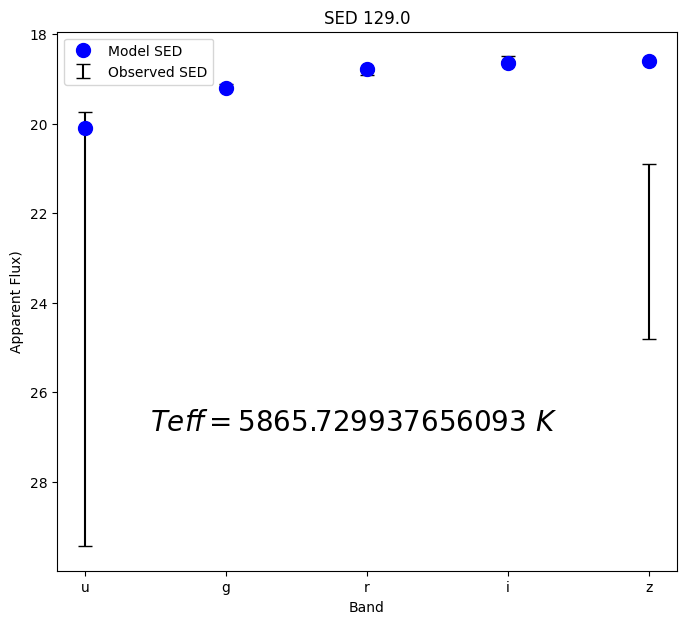

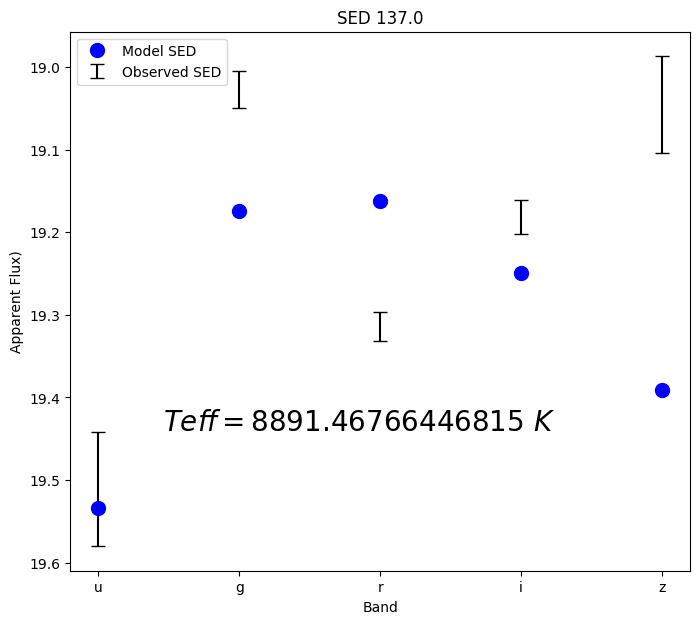

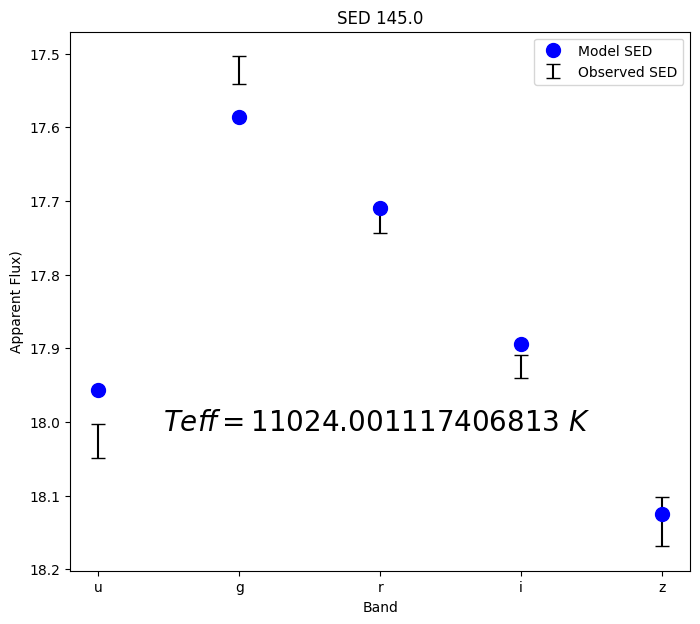

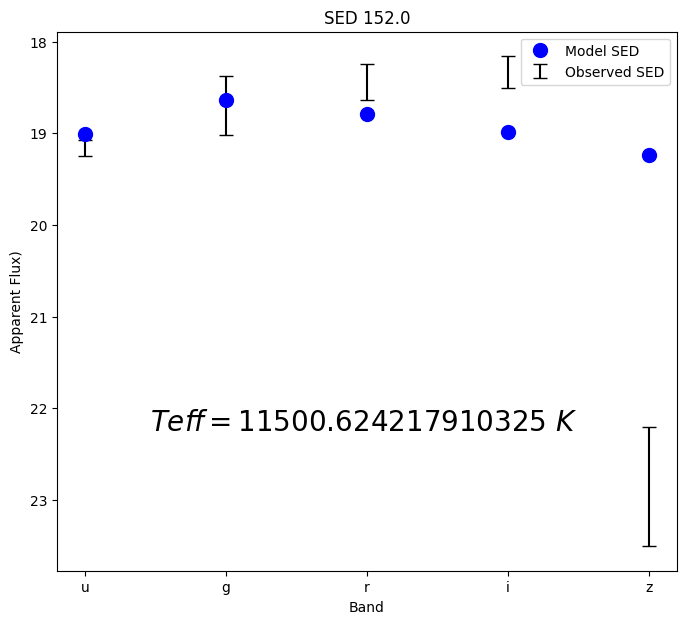

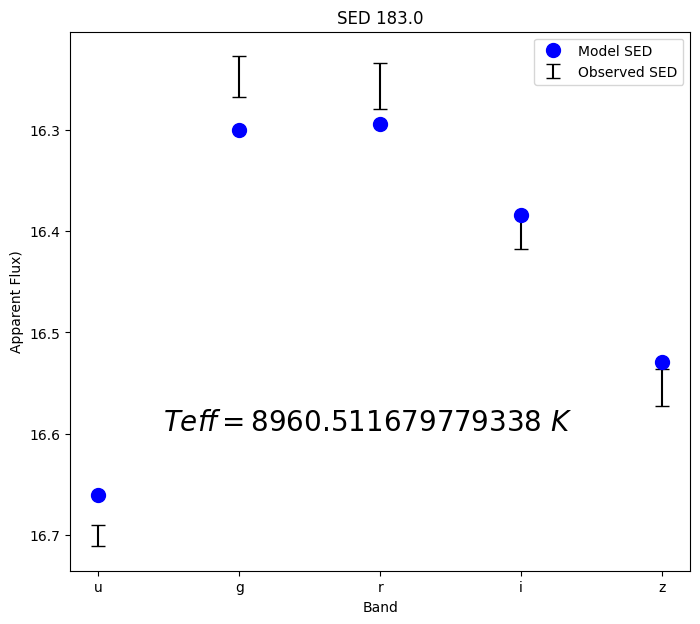

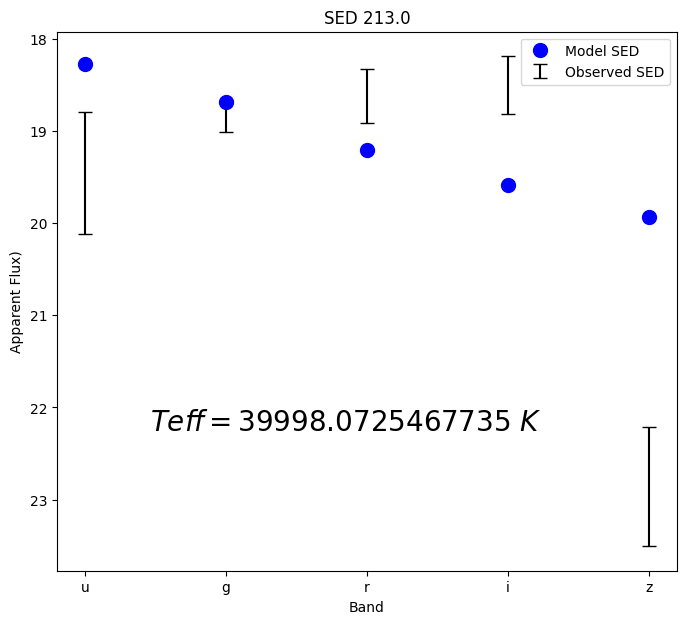

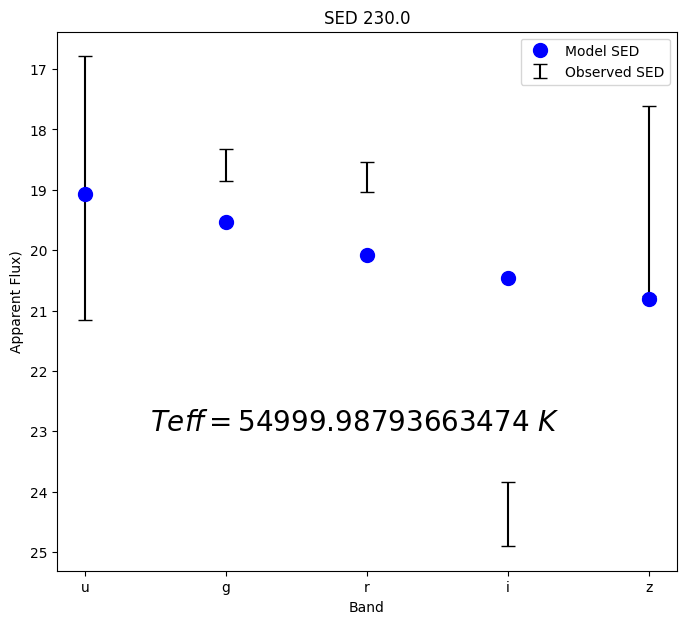

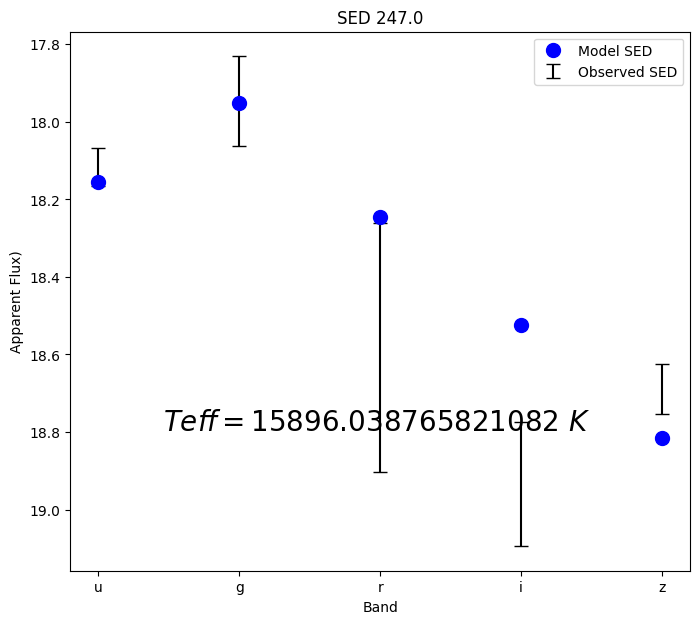

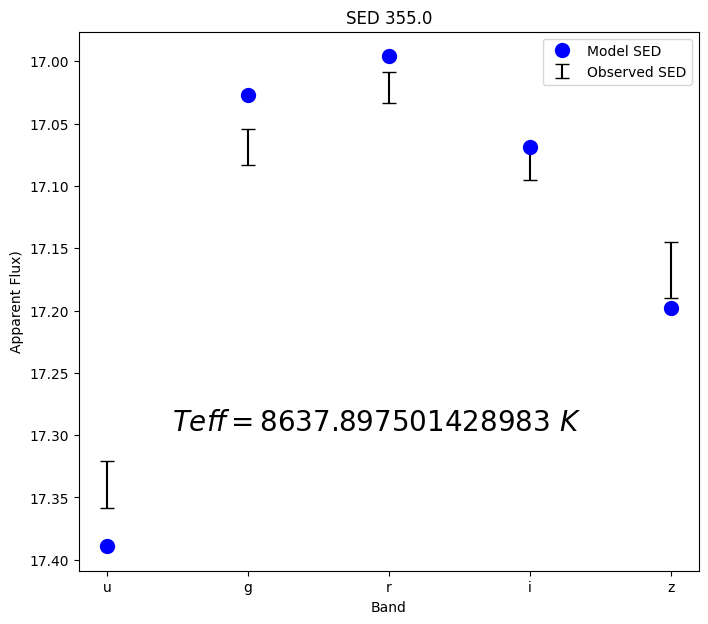

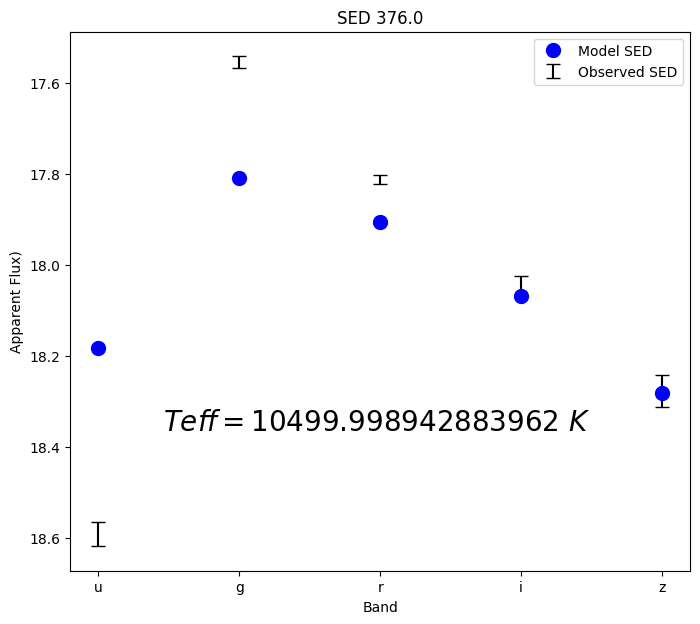

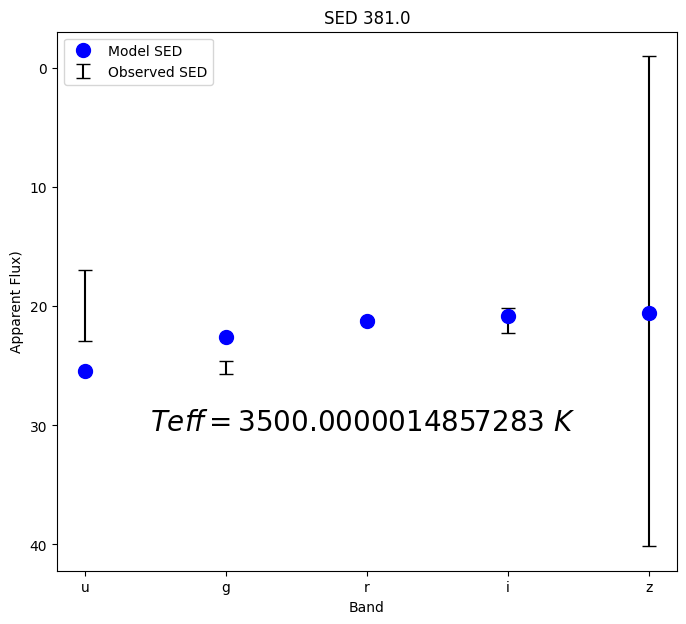

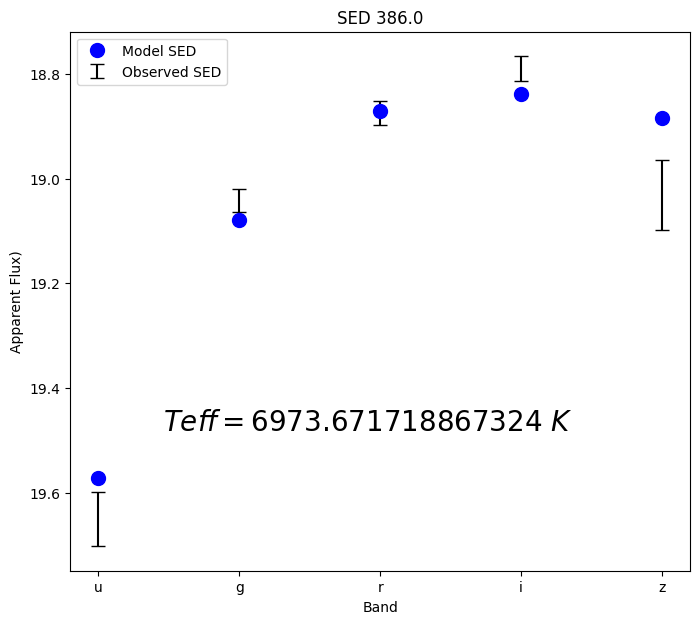

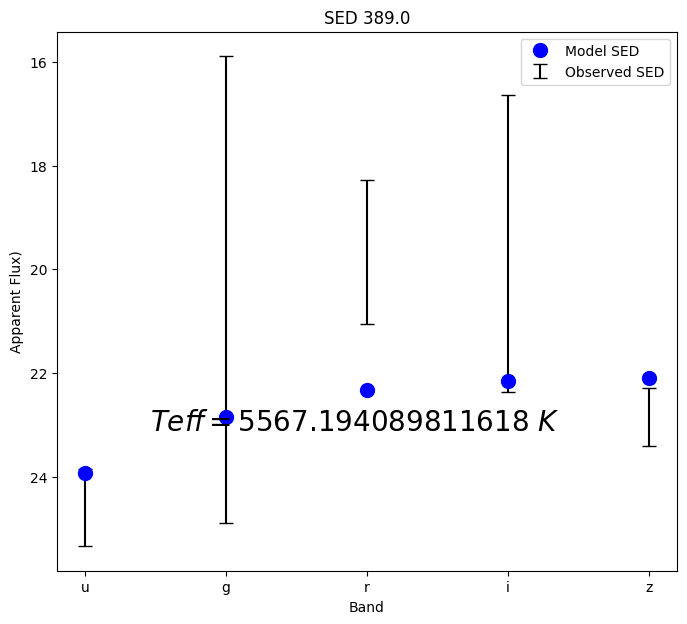

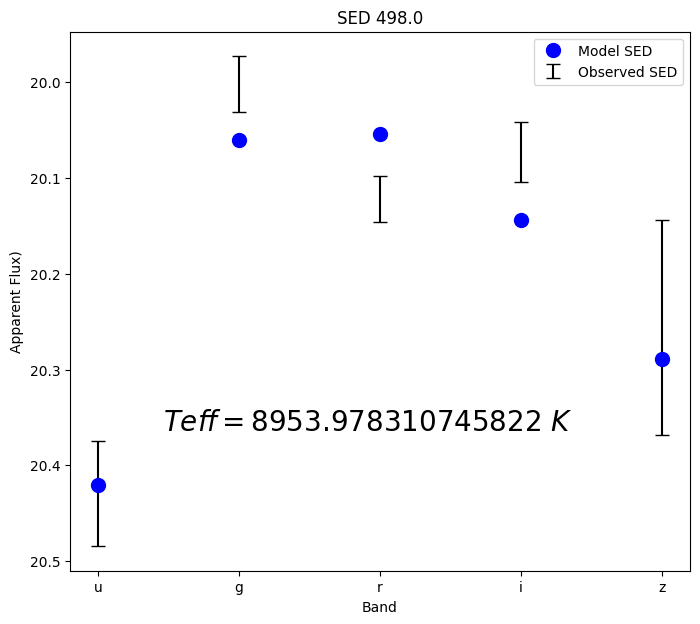

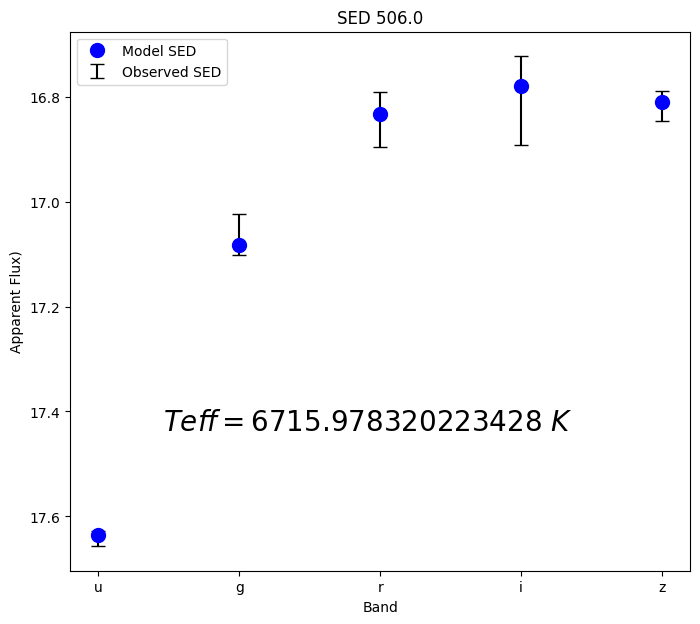

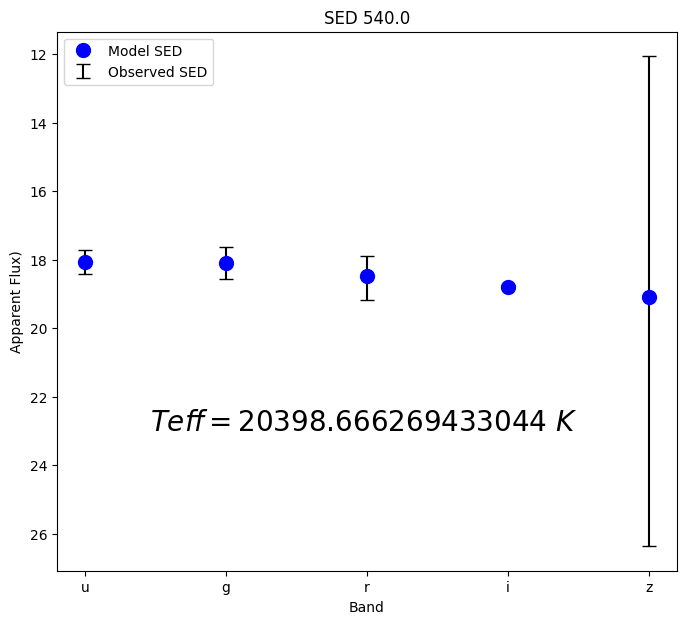

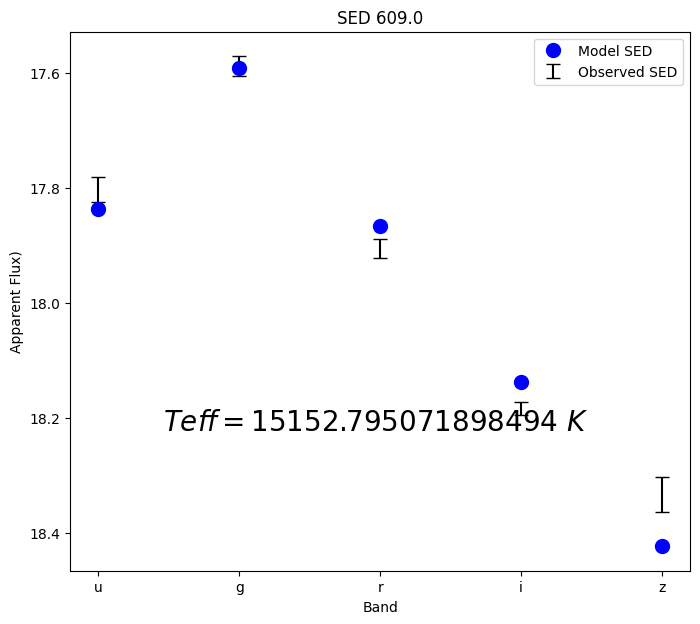

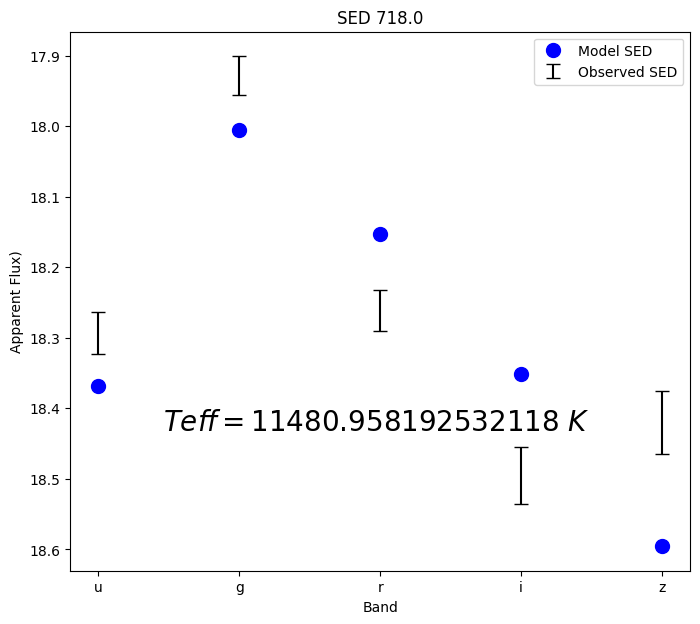

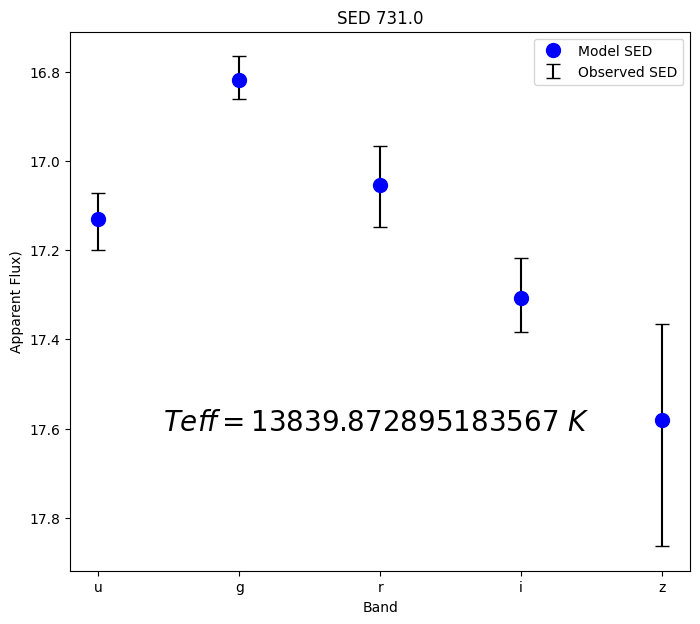

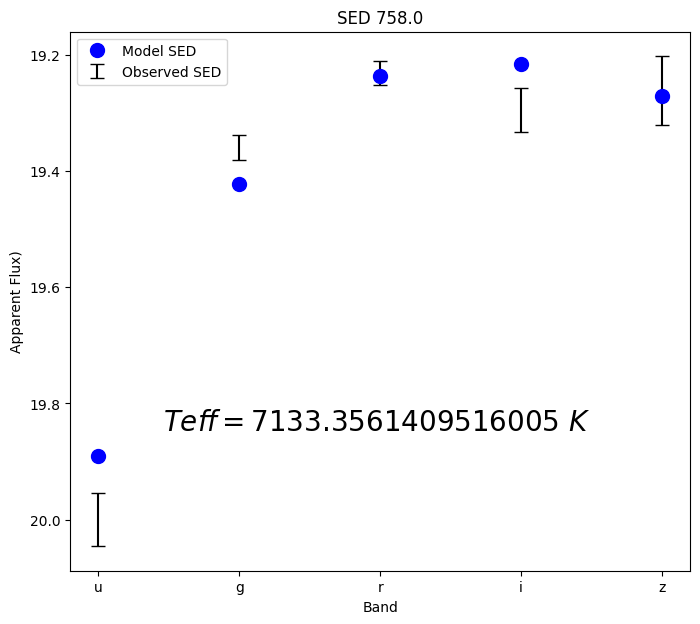

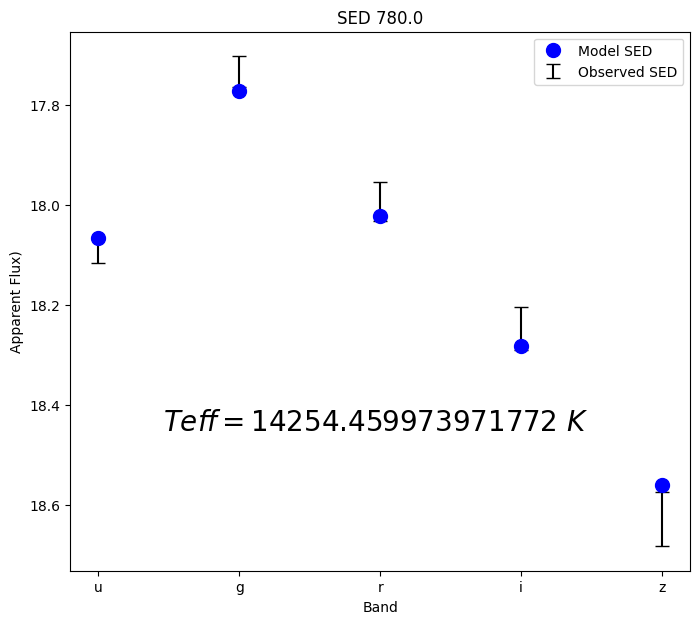

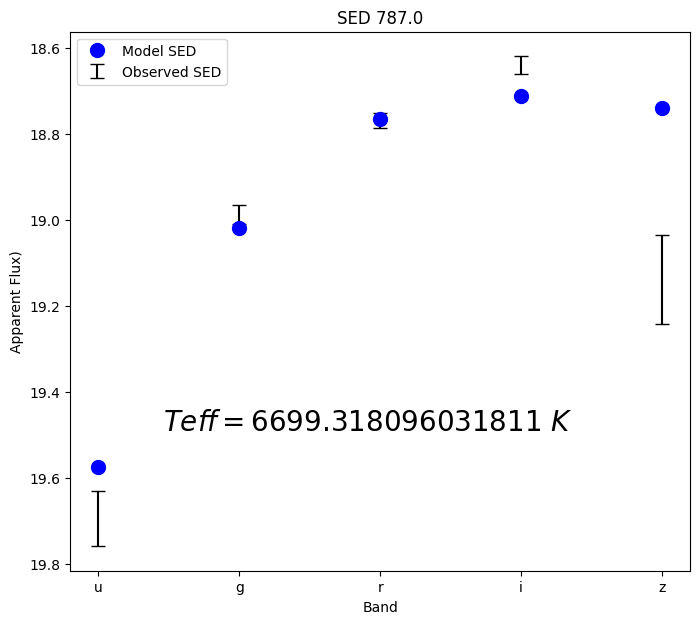

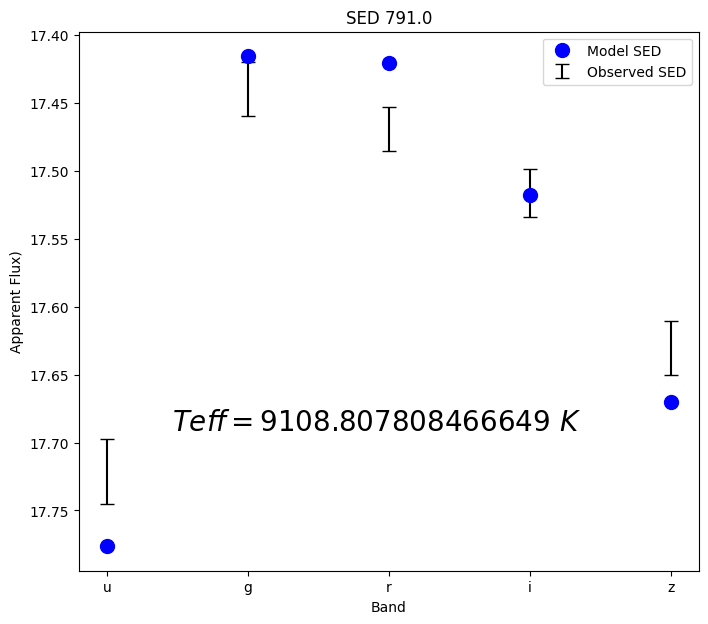

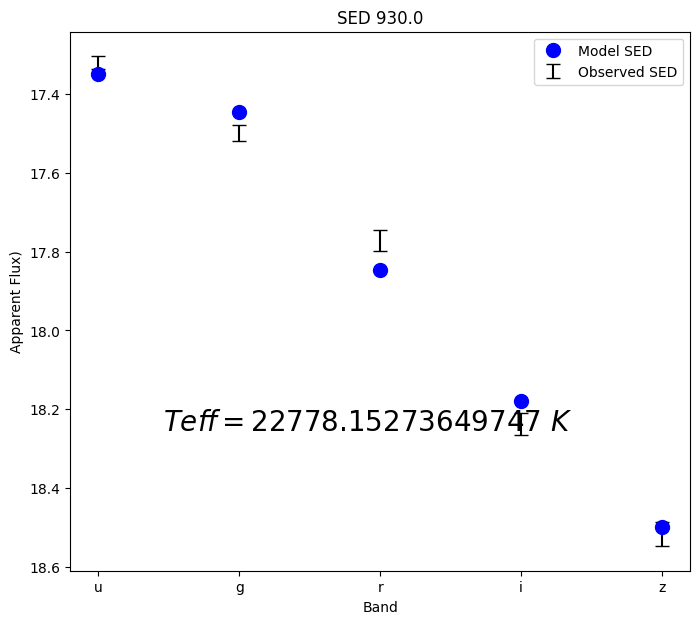

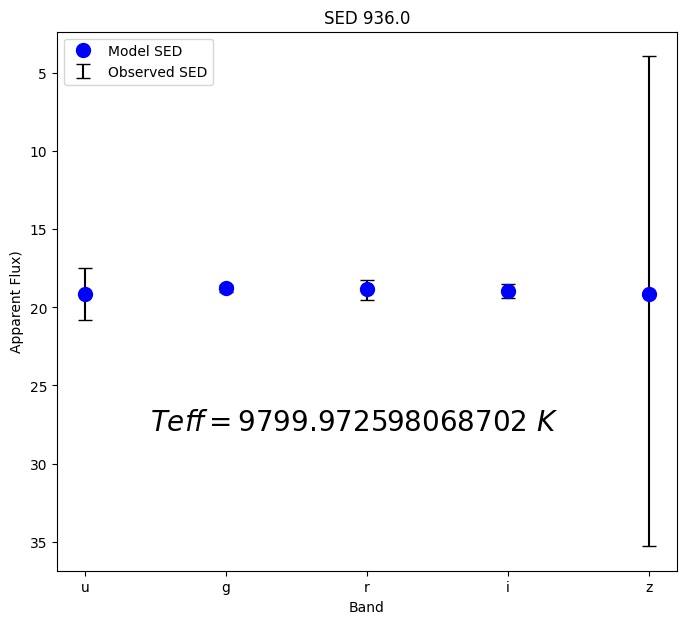

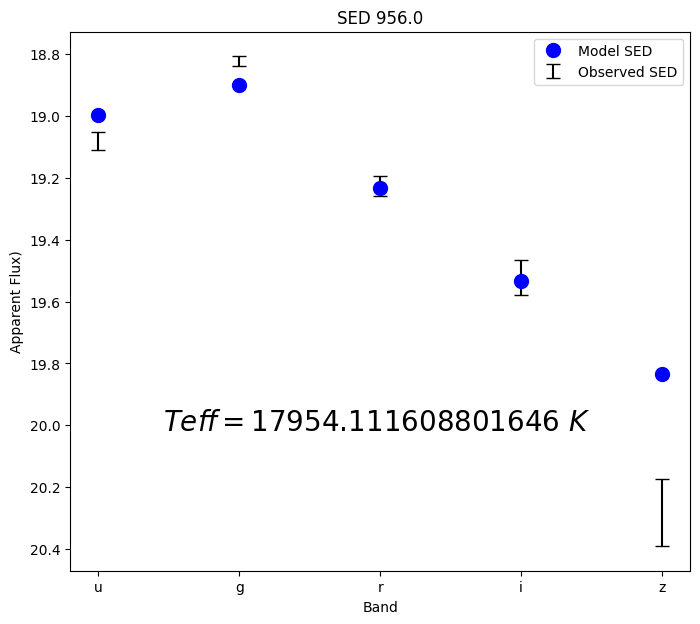

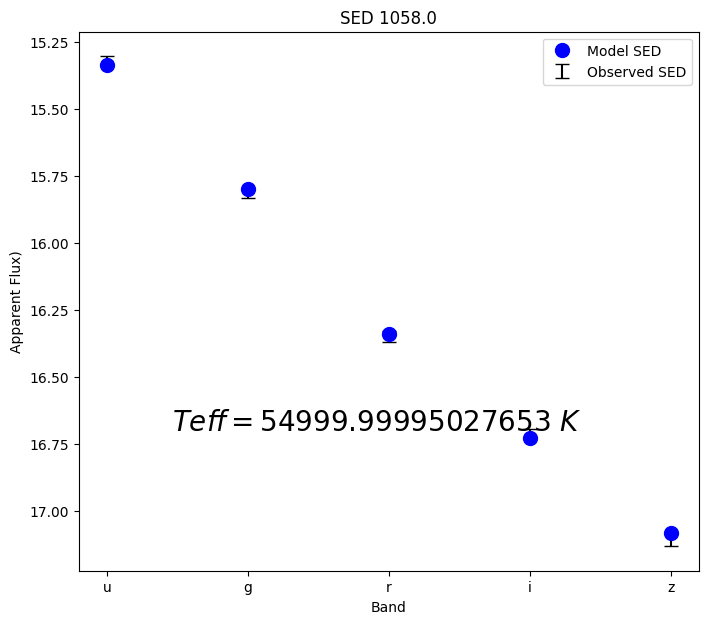

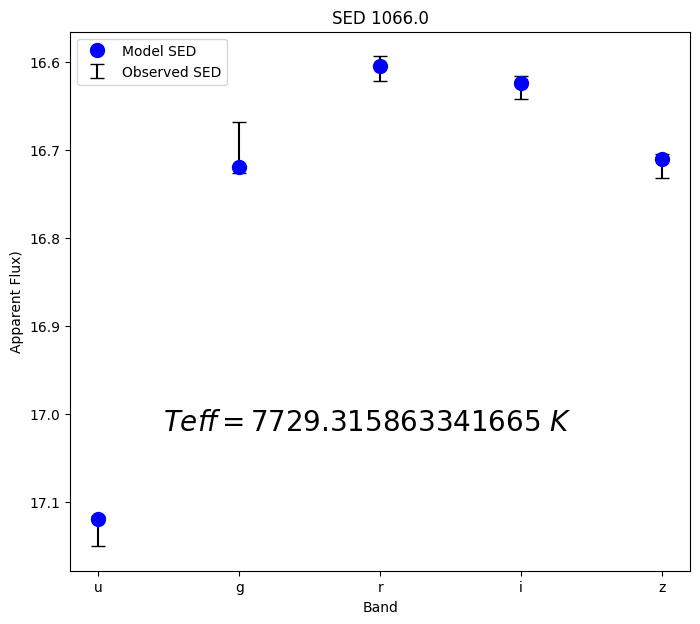

In [141]:
refs = Table.read('data/masked_sourceids.fits')

for i in tqdm(range(len(catalog))):
    if catalog['wd_source_id'][i] in refs['wd_source_id']:
        bands = ['u', 'g', 'r', 'i', 'z']
        
        fig = plt.figure(figsize = (8,7))
        plt.errorbar(bands, [catalog['u'][i] - 0.040, catalog['g'][i], catalog['r'][i], catalog['i'][i] + 0.015, catalog['z'][i] + 0.030],
                     yerr = [catalog['err_u'][i], catalog['err_g'][i], catalog['err_r'][i], catalog['err_i'][i], catalog['err_z'][i]],
                     linestyle = 'none', marker = 'None', color = 'k', capsize = 5, label = 'Observed SED')
        plt.plot(bands, get_model_flux(results[i].params), 'bo', markersize = 10, label = 'Model SED')
        plt.title('SED {}'.format(catalog['phot_id'][i]))
        plt.text(0.15, 0.26, r'$Teff = ${} $K$'.format(results[i].params['teff'].value), transform = plt.gca().transAxes, fontsize=20)
        plt.xlabel('Band')
        plt.ylabel('Apparent Flux)')
        plt.gca().invert_yaxis()
        plt.legend() 
        plt.savefig('./spectra/bad/{}.png'.format(catalog['phot_id'][i]))

In [ ]:
model = WD_models.load_model('f', 'f', 'f', 'H')
font_model = model

def rv_from_radius(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f'):
    
    if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
        font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    else:
        font_model = model

    #     font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')


    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**font_model['logteff'],\
                                                z = font_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)

    return rv*1e-3

In [ ]:
fontaine_model = WD_models.load_model('f', 'f', 'f', 'H')

In [ ]:
'''#tcatalog = catalog
raw_catalog = catalog

#catalog = tcatalog
#catalog = catalog[catalog['redchi'] < 2.5]
#catalog = catalog[catalog['wd_parallax_over_error'] > 10]
#catalog = catalog[catalog['e_radius'] != None]
#catalog = catalog[catalog['e_radius'] < 0.01]

vary_catalog = vary_catalog[vary_catalog['redchi'] < 2.5]
vary_catalog = vary_catalog[vary_catalog['wd_parallax_over_error'] > 10]
vary_catalog = vary_catalog[vary_catalog['e_radius'] != None]
vary_catalog = vary_catalog[vary_catalog['e_radius'] < 0.01]

print(catalog[['radius', 'e_radius', 'g_redshift', 'eg_redshift', 'redchi']])

plt.figure(figsize=(10,8))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

plt.errorbar(catalog['radius'], catalog['g_redshift'], xerr = catalog['e_radius'], yerr=catalog['eg_redshift'], fmt='o', label = 'logg = 8')

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(0, 120)
plt.legend()
plt.savefig('plots/photometry/gredshift_vs_radius.jpg')'''

In [ ]:
plt.figure(figsize=(10,10))

plt.scatter(alldat['wd_bp_rp'], alldat['wd_m_g'], label='White Dwarf', alpha = 0.5, s=5)
plt.scatter(catalog['wd_bp_rp'], catalog['wd_m_g'], label='Kept Stars', alpha = 1, s=5)

plt.grid()
plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.hist(catalog['phot_teff'], bins = 20, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog['phot_teff']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Photometric Temp $[K]$', fontsize=18)
plt.savefig('plots/photometry/radius.png')

In [ ]:
from lmfit import Parameters, fit_report, minimize

print(fit_report(catalog['raw_radius_result'][catalog['phot_id'] == 494][0]))
#catalog['raw_radius_result'][catalog['phot_id'] == 494][0].success

In [ ]:
catalog.remove_columns(['wd_m_g','wd_bp_rp', 'raw_radius_result'])

catalog.write('data/02_photometry_ned.fits', overwrite=True)


In [ ]:
nug = catalog[['wd_source_id', 'phot_teff', 'e_phot_teff', 'converged', 'reliable_dist']]
nug.write('data/nug.fits', overwrite = True)